# Spotify Music Genre Clustering Analysis
## Comprehensive Evaluation on 170K+ Tracks

This notebook performs unsupervised clustering analysis on the Spotify dataset with 171,655 entries using multiple clustering algorithms with extensive evaluation metrics and visualizations logged to Weights & Biases.

In [4]:
# Install required packages
!pip install -q wandb scikit-learn pandas numpy matplotlib seaborn tqdm plotly

In [5]:
# Import libraries
import os, warnings, math, itertools
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.cluster import KMeans, MiniBatchKMeans, SpectralClustering, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN, OPTICS, Birch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import (
    silhouette_score, davies_bouldin_score, calinski_harabasz_score,
    normalized_mutual_info_score, adjusted_rand_score, confusion_matrix,
    silhouette_samples
)
from scipy.optimize import linear_sum_assignment
from scipy.cluster.hierarchy import dendrogram, linkage

import wandb

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

print("✅ All libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Scikit-learn version: {__import__('sklearn').__version__}")

✅ All libraries imported successfully!
Pandas version: 2.2.3
NumPy version: 1.26.4
Scikit-learn version: 1.2.2


In [ ]:
# Initialize W&B
wandb.login(key="")
print("✅ Logged into Weights & Biases!")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: anis42390 (anis42390-national-institute-of-technology-hamirpur) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


✅ Logged into Weights & Biases!


# 📊 1. Data Loading & Exploration

In [7]:
# Load Spotify dataset
DATA_PATH = "/kaggle/input/spotify-music-features-dataset/Spotify/data/data.csv"

df = pd.read_csv(DATA_PATH)

# Use only first 20k entries
df = df.head(20000)

print(f"✅ Dataset loaded successfully!")
print(f"📊 Dataset shape: {df.shape}")
print(f"📝 Total tracks: {len(df):,}")
print(f"\n🎵 Columns: {list(df.columns)}")
print(f"\n📈 Dataset info:")
df.info()

✅ Dataset loaded successfully!
📊 Dataset shape: (20000, 19)
📝 Total tracks: 20,000

🎵 Columns: ['valence', 'year', 'acousticness', 'artists', 'danceability', 'duration_ms', 'energy', 'explicit', 'id', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'name', 'popularity', 'release_date', 'speechiness', 'tempo']

📈 Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   valence           20000 non-null  float64
 1   year              20000 non-null  int64  
 2   acousticness      20000 non-null  float64
 3   artists           20000 non-null  object 
 4   danceability      20000 non-null  float64
 5   duration_ms       20000 non-null  int64  
 6   energy            20000 non-null  float64
 7   explicit          20000 non-null  int64  
 8   id                20000 non-null  object 
 9   instrumentalness  20000 non-nu

In [8]:
# Display first few rows and basic statistics
print("📋 First 10 rows:")
display(df.head(10))

print("\n📊 Statistical Summary:")
display(df.describe())

📋 First 10 rows:


valence  year  acousticness  \
0   0.0594  1921         0.982   
1   0.9630  1921         0.732   
2   0.0394  1921         0.961   
3   0.1650  1921         0.967   
4   0.2530  1921         0.957   
5   0.1960  1921         0.579   
6   0.4060  1921         0.996   
7   0.0731  1921         0.993   
8   0.7210  1921         0.996   
9   0.7710  1921         0.982   

                                             artists  danceability  \
0  ['Sergei Rachmaninoff', 'James Levine', 'Berli...         0.279   
1                                     ['Dennis Day']         0.819   
2  ['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...         0.328   
3                                   ['Frank Parker']         0.275   
4                                     ['Phil Regan']         0.418   
5  ['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...         0.697   
6                                 ['John McCormack']         0.518   
7                            ['Sergei Rachmaninoff']         0.389   
8                                ['Ignacio Corsini']         0.485   
9                                        ['Fortugé']         0.684   

   duration_ms  energy  explicit                      id  instrumentalness  \
0       831667   0.211         0  4BJqT0PrAfrxzMOxytFOIz          0.878000   
1       180533   0.341         0  7xPhfUan2yNtyFG0cUWkt8          0.000000   
2       500062   0.166         0  1o6I8BglA6ylDMrIELygv1          0.913000   
3       210000   0.309         0  3ftBPsC5vPBKxYSee08FDH          0.000028   
4       166693   0.193         0  4d6HGyGT8e121BsdKmw9v6          0.000002   
5       395076   0.346         0  4pyw9DVHGStUre4J6hPngr          0.168000   
6       159507   0.203         0  5uNZnElqOS3W4fRmRYPk4T          0.000000   
7       218773   0.088         0  02GDntOXexBFUvSgaXLPkd          0.527000   
8       161520   0.130         0  05xDjWH9ub67nJJk82yfGf          0.151000   
9       196560   0.257         0  08zfJvRLp7pjAb94MA9JmF          0.000000   

   key  liveness  loudness  mode  \
0   10     0.665   -20.096     1   
1    7     0.160   -12.441     1   
2    3     0.101   -14.850     1   
3    5     0.381    -9.316     1   
4    3     0.229   -10.096     1   
5    2     0.130   -12.506     1   
6    0     0.115   -10.589     1   
7    1     0.363   -21.091     0   
8    5     0.104   -21.508     0   
9    8     0.504   -16.415     1   

                                                name  popularity release_date  \
0  Piano Concerto No. 3 in D Minor, Op. 30: III. ...           4         1921   
1                            Clancy Lowered the Boom           5         1921   
2                                          Gati Bali           5         1921   
3                                          Danny Boy           3         1921   
4                        When Irish Eyes Are Smiling           2         1921   
5                                       Gati Mardika           6         1921   
6                           The Wearing of the Green           4         1921   
7  Morceaux de fantaisie, Op. 3: No. 2, Prélude i...           2         1921   
8                        La Mañanita - Remasterizado           0   1921-03-20   
9                                  Il Etait Syndiqué           0         1921   

   speechiness    tempo  
0       0.0366   80.954  
1       0.4150   60.936  
2       0.0339  110.339  
3       0.0354  100.109  
4       0.0380  101.665  
5       0.0700  119.824  
6       0.0615   66.221  
7       0.0456   92.867  
8       0.0483   64.678  
9       0.3990  109.378


📊 Statistical Summary:


valence          year  acousticness  danceability   duration_ms  \
count  20000.000000  20000.000000  20000.000000  20000.000000  2.000000e+04   
mean       0.551710   1970.533050      0.518650      0.562784  2.220700e+05   
std        0.252771     28.812977      0.380454      0.168016  1.005277e+05   
min        0.000000   1921.000000      0.000000      0.000000  1.037100e+04   
25%        0.352750   1945.750000      0.111000      0.451000  1.705600e+05   
50%        0.568000   1970.500000      0.550500      0.576000  2.017070e+05   
75%        0.760000   1995.250000      0.917000      0.686000  2.530702e+05   
max        0.991000   2020.000000      0.996000      0.988000  3.499774e+06   

             energy      explicit  instrumentalness           key  \
count  20000.000000  20000.000000      20000.000000  20000.000000   
mean       0.469480      0.090600          0.142357      5.206300   
std        0.260912      0.287047          0.297246      3.487069   
min        0.000020      0.000000          0.000000      0.000000   
25%        0.250000      0.000000          0.000000      2.000000   
50%        0.450000      0.000000          0.000070      5.000000   
75%        0.683000      0.000000          0.031000      8.000000   
max        1.000000      1.000000          1.000000     11.000000   

           liveness      loudness          mode   popularity   speechiness  \
count  20000.000000  20000.000000  20000.000000  20000.00000  20000.000000   
mean       0.194445    -11.236567      0.716250     42.86600      0.093358   
std        0.156853      5.351563      0.450828     26.29101      0.150128   
min        0.000000    -47.046000      0.000000      0.00000      0.000000   
25%        0.096900    -14.203000      0.000000     15.00000      0.034800   
50%        0.134000    -10.593000      1.000000     52.00000      0.045200   
75%        0.248000     -7.175750      1.000000     64.00000      0.075400   
max        0.997000      0.878000      1.000000    100.00000      0.967000   

              tempo  
count  20000.000000  
mean     116.995641  
std       30.763279  
min        0.000000  
25%       93.998500  
50%      114.683500  
75%      134.753500  
max      221.741000

In [9]:
# Check for missing values
print("🔍 Missing Values Check:")
missing_data = df.isnull().sum()
if missing_data.sum() > 0:
    print(missing_data[missing_data > 0])
    print(f"\n⚠️  Total missing values: {missing_data.sum()}")
else:
    print("✅ No missing values found!")

# Check data types
print("\n📝 Data Types:")
print(df.dtypes)

🔍 Missing Values Check:
✅ No missing values found!

📝 Data Types:
valence             float64
year                  int64
acousticness        float64
artists              object
danceability        float64
duration_ms           int64
energy              float64
explicit              int64
id                   object
instrumentalness    float64
key                   int64
liveness            float64
loudness            float64
mode                  int64
name                 object
popularity            int64
release_date         object
speechiness         float64
tempo               float64
dtype: object


# 🎨 2. Exploratory Data Analysis with Visualizations

In [10]:
# Select numeric features for clustering
numeric_features = ['valence', 'acousticness', 'danceability', 'duration_ms', 
                    'energy', 'instrumentalness', 'key', 'liveness', 
                    'loudness', 'mode', 'speechiness', 'tempo', 'year', 'popularity']

print(f"🎯 Selected {len(numeric_features)} numeric features for clustering:")
for i, feat in enumerate(numeric_features, 1):
    print(f"  {i}. {feat}")

# Check if all features exist in dataset
missing_features = [f for f in numeric_features if f not in df.columns]
if missing_features:
    print(f"\n⚠️  Missing features: {missing_features}")
else:
    print(f"\n✅ All {len(numeric_features)} features are available in the dataset!")

🎯 Selected 14 numeric features for clustering:
  1. valence
  2. acousticness
  3. danceability
  4. duration_ms
  5. energy
  6. instrumentalness
  7. key
  8. liveness
  9. loudness
  10. mode
  11. speechiness
  12. tempo
  13. year
  14. popularity

✅ All 14 features are available in the dataset!


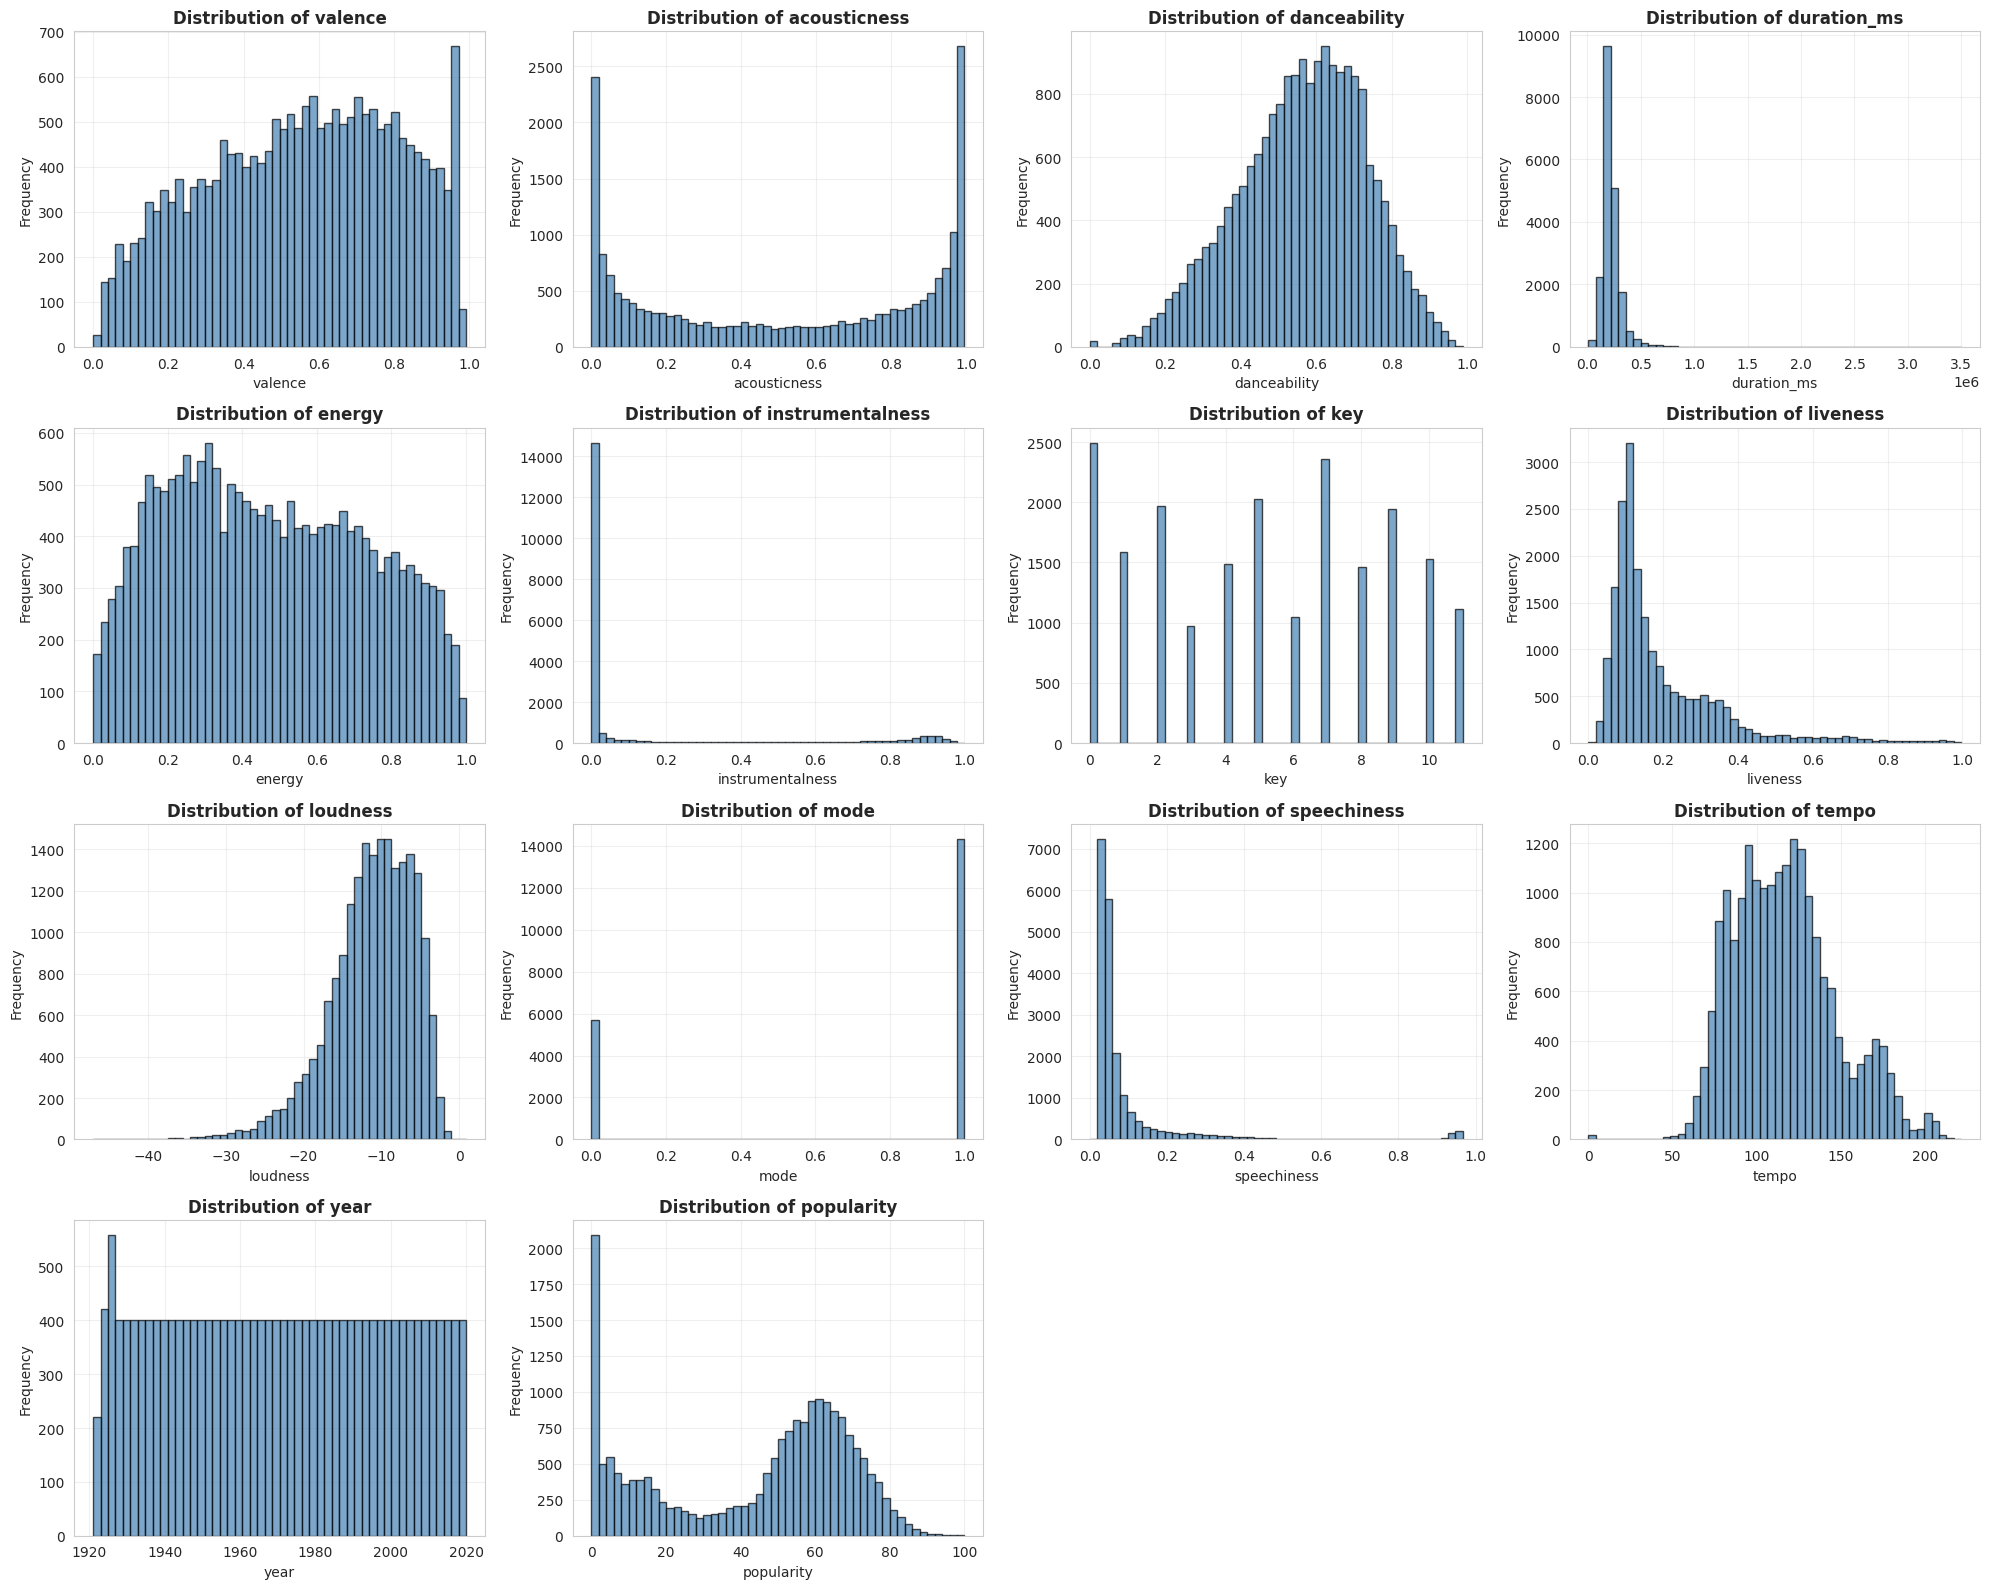

📊 Visualization 1-14: Feature distributions created!


In [11]:
# Feature distributions - Visualization 1-14
fig, axes = plt.subplots(4, 4, figsize=(20, 16))
axes = axes.ravel()

for idx, feature in enumerate(numeric_features):
    if idx < len(axes):
        axes[idx].hist(df[feature].dropna(), bins=50, color='steelblue', edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'Distribution of {feature}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel(feature)
        axes[idx].set_ylabel('Frequency')
        axes[idx].grid(True, alpha=0.3)

# Hide empty subplots
for idx in range(len(numeric_features), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('feature_distributions.png', dpi=150, bbox_inches='tight')
plt.show()
print("📊 Visualization 1-14: Feature distributions created!")

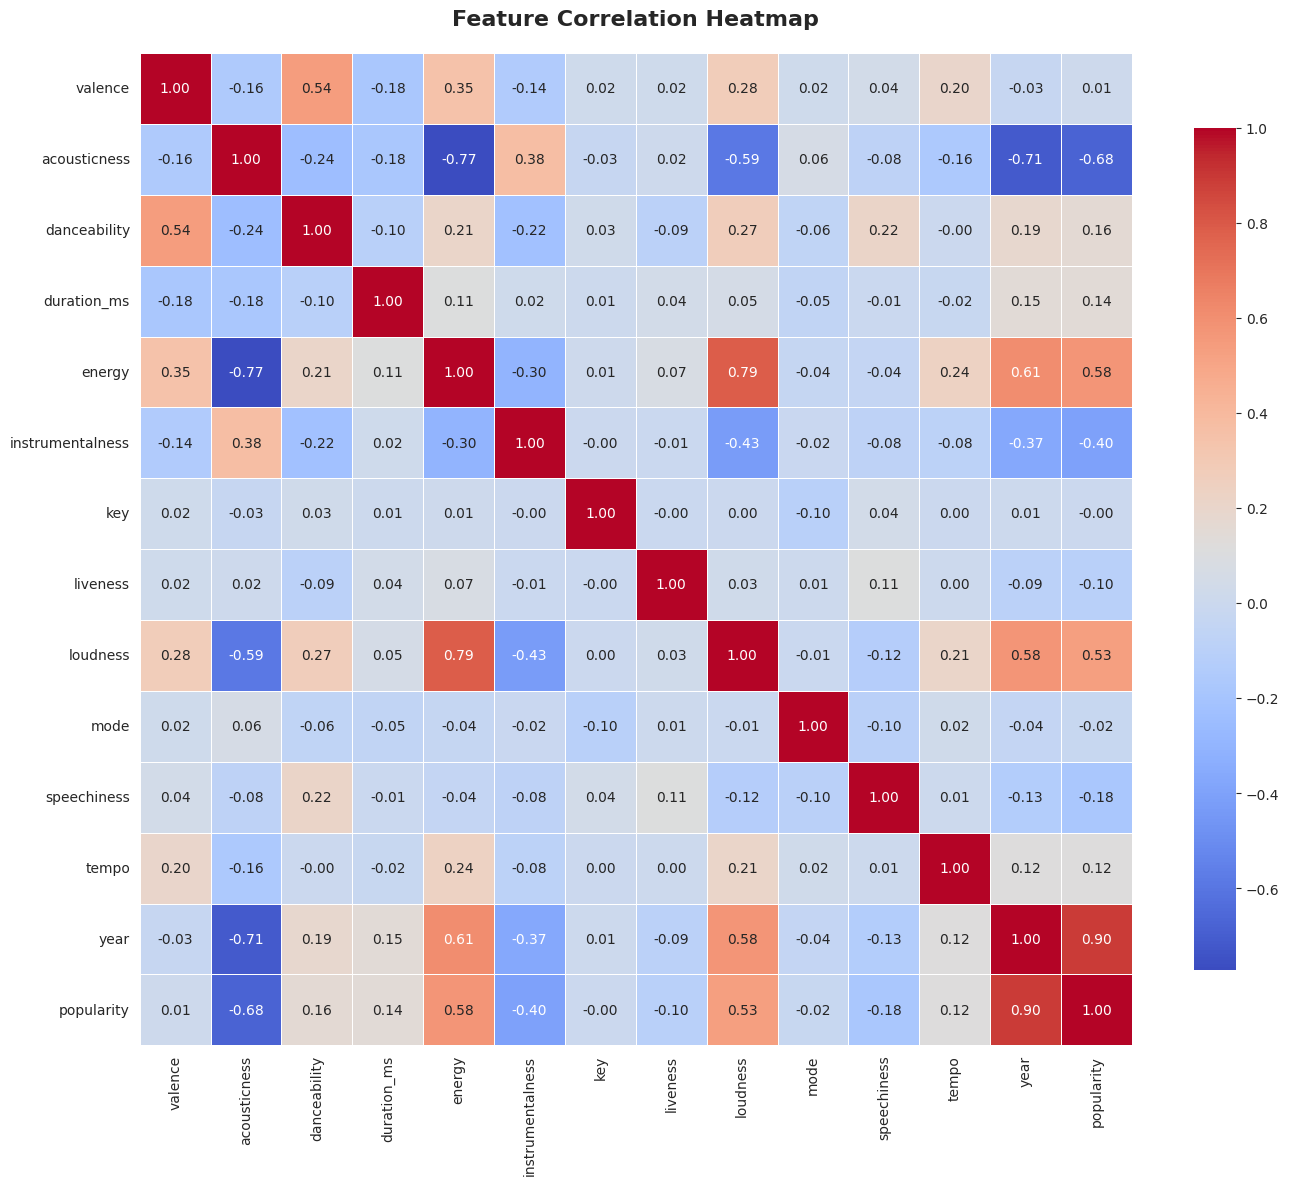

📊 Visualization 15: Correlation heatmap created!


In [12]:
# Correlation heatmap - Visualization 15
plt.figure(figsize=(14, 12))
correlation_matrix = df[numeric_features].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()
print("📊 Visualization 15: Correlation heatmap created!")

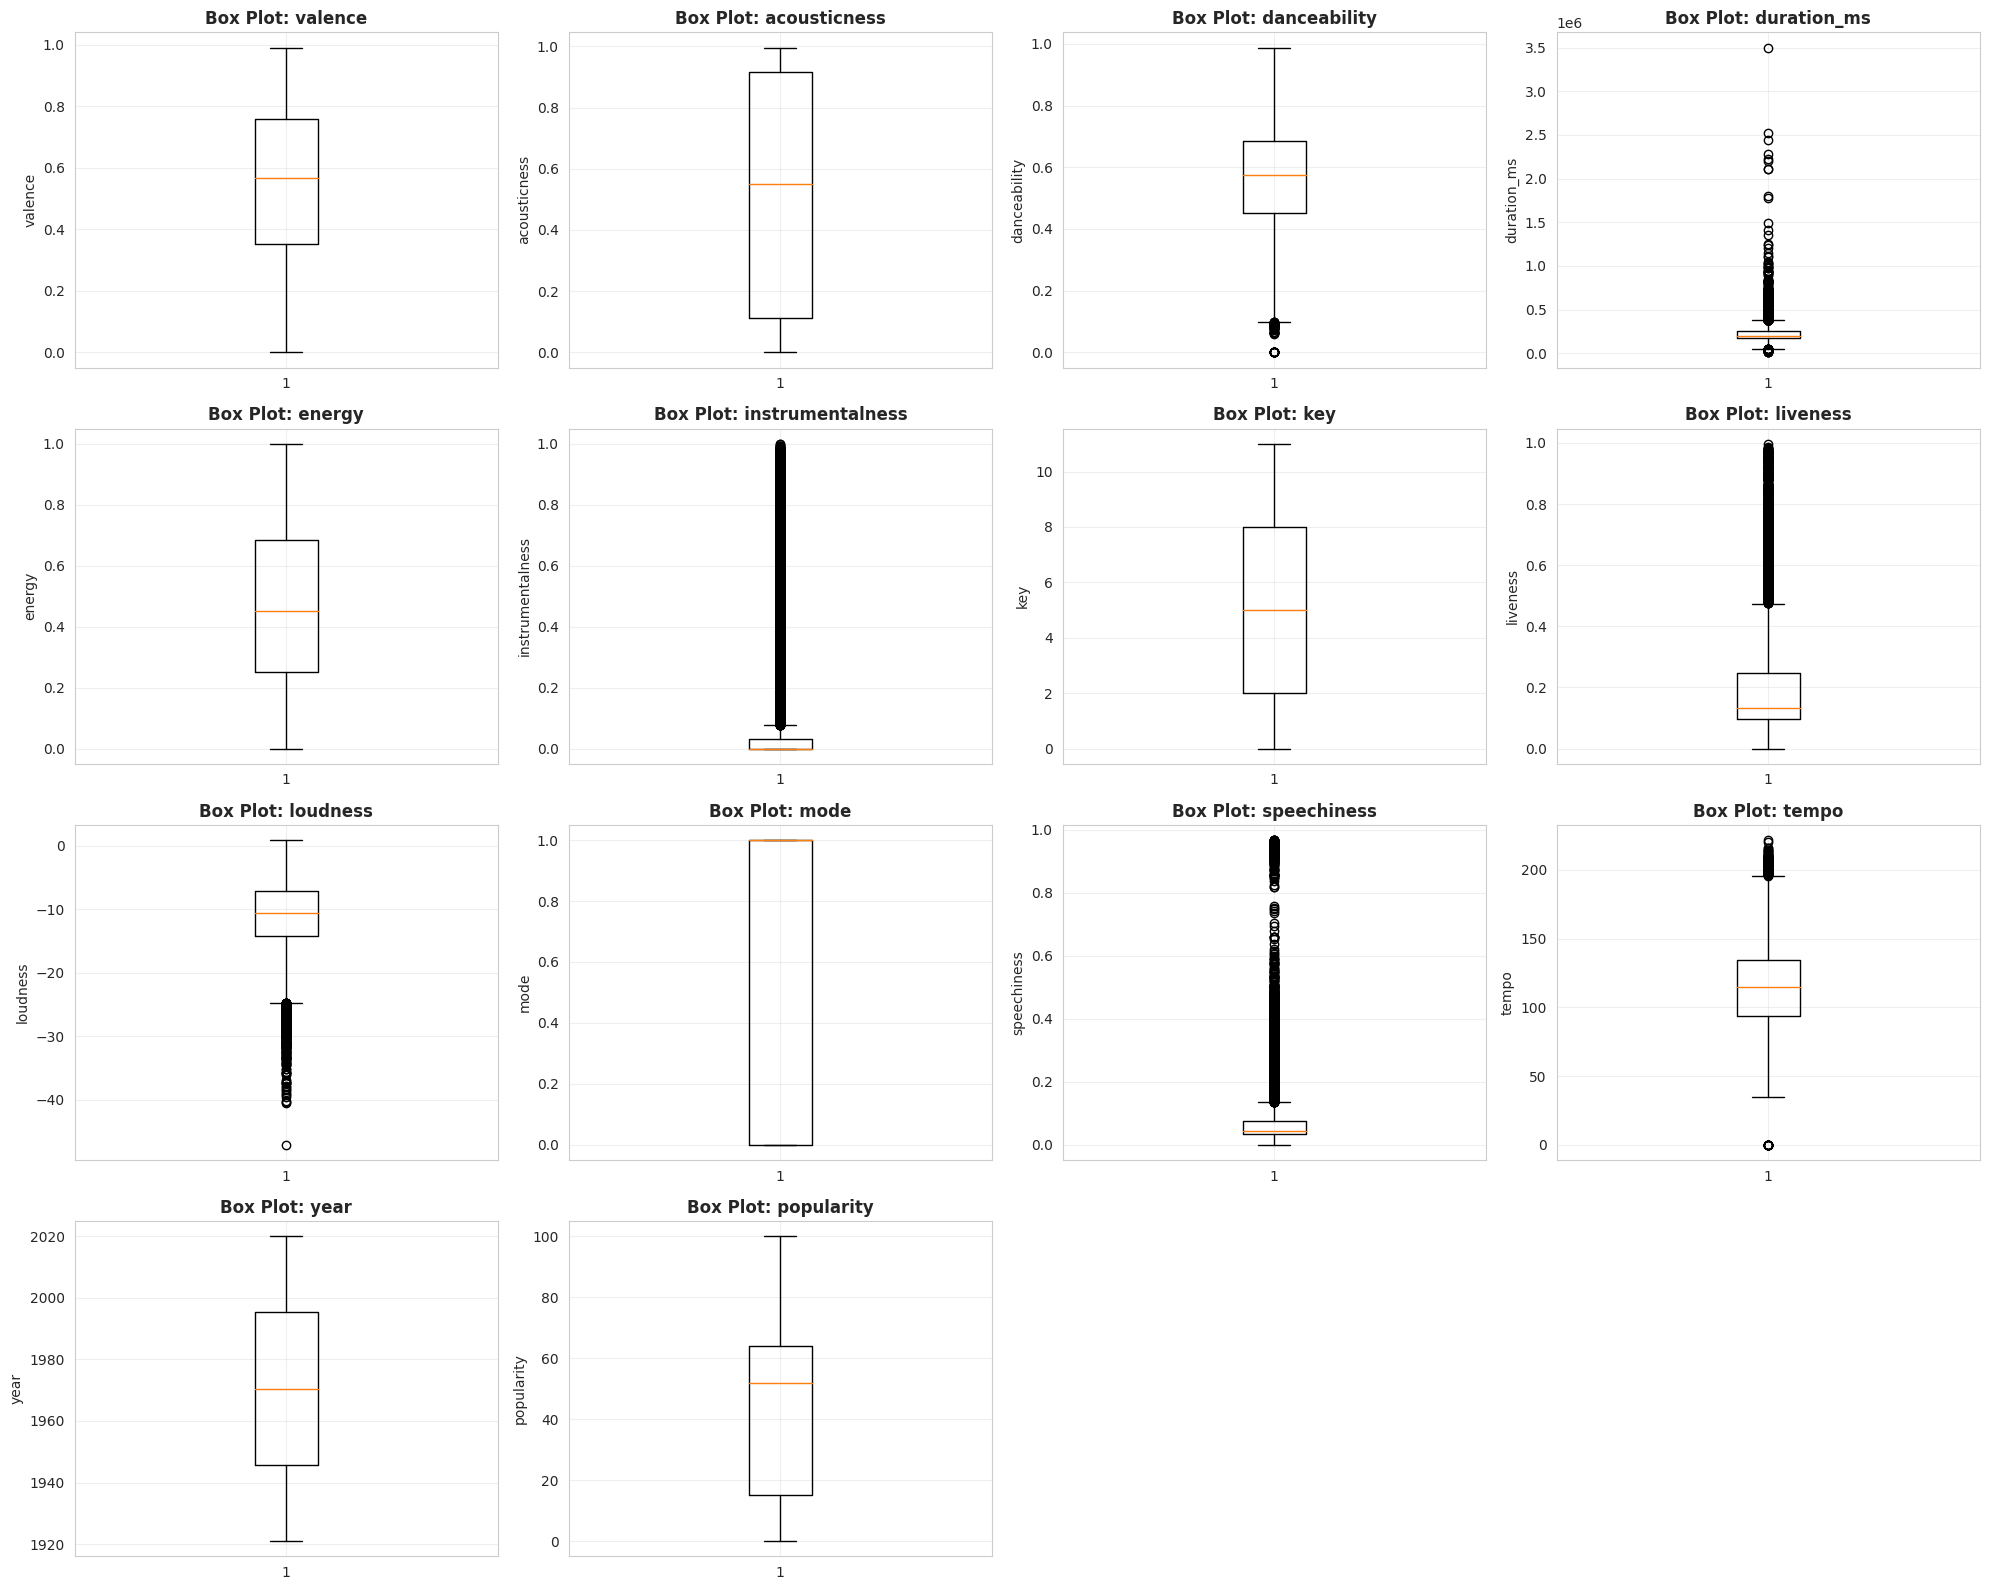

📊 Visualization 16-29: Box plots created!


In [13]:
# Box plots for feature distributions - Visualization 16-29
fig, axes = plt.subplots(4, 4, figsize=(20, 16))
axes = axes.ravel()

for idx, feature in enumerate(numeric_features):
    if idx < len(axes):
        axes[idx].boxplot(df[feature].dropna(), vert=True)
        axes[idx].set_title(f'Box Plot: {feature}', fontsize=12, fontweight='bold')
        axes[idx].set_ylabel(feature)
        axes[idx].grid(True, alpha=0.3)

for idx in range(len(numeric_features), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('feature_boxplots.png', dpi=150, bbox_inches='tight')
plt.show()
print("📊 Visualization 16-29: Box plots created!")

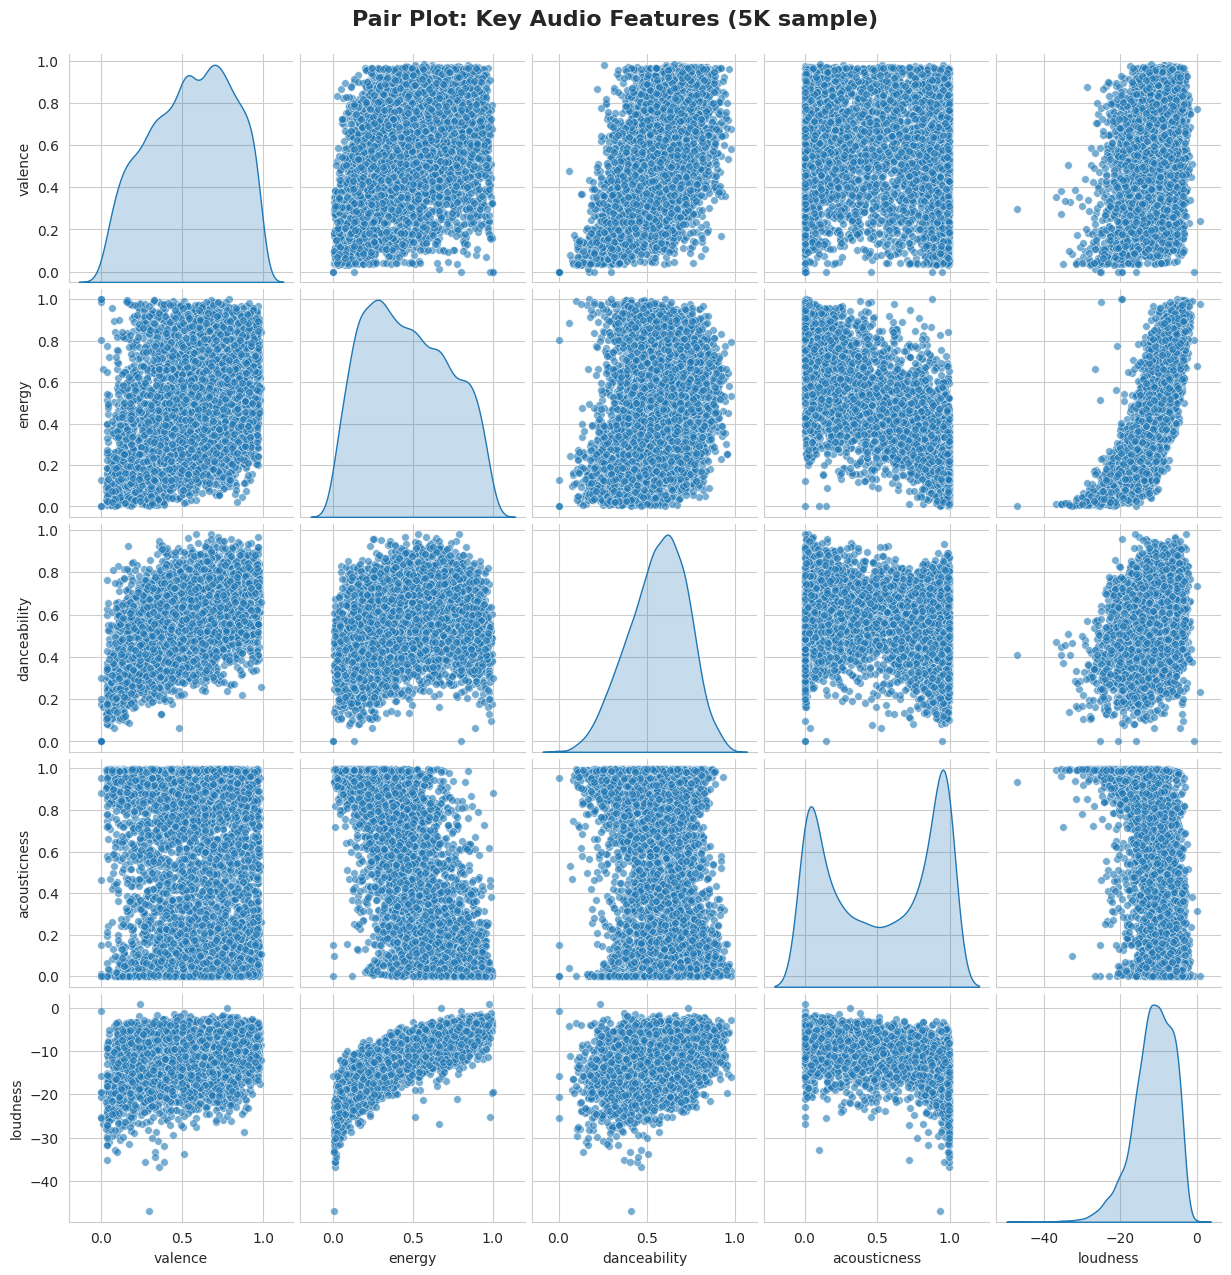

📊 Visualization 30: Pair plot created!


In [14]:
# Pair plot for key features - Visualization 30
key_features = ['valence', 'energy', 'danceability', 'acousticness', 'loudness']
sample_df = df[key_features].sample(n=min(5000, len(df)), random_state=42)

pair_plot = sns.pairplot(sample_df, diag_kind='kde', plot_kws={'alpha': 0.6, 's': 30})
pair_plot.fig.suptitle('Pair Plot: Key Audio Features (5K sample)', y=1.02, fontsize=16, fontweight='bold')
plt.savefig('pairplot_key_features.png', dpi=150, bbox_inches='tight')
plt.show()
print("📊 Visualization 30: Pair plot created!")

# 🔧 3. Data Preprocessing & Feature Engineering

In [15]:
# Prepare data for clustering
# Remove non-numeric columns
drop_cols = ['artists', 'id', 'name', 'release_date']
drop_cols = [c for c in drop_cols if c in df.columns]

# Handle explicit column (convert to numeric if needed)
if 'explicit' in df.columns:
    df['explicit'] = df['explicit'].astype(int)

# Extract features
X = df[numeric_features].values.astype(float)

# Handle any remaining NaN values
if np.isnan(X).any():
    print("⚠️  Handling NaN values...")
    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(strategy='median')
    X = imputer.fit_transform(X)
    print("✅ NaN values handled!")

print(f"✅ Feature matrix shape: {X.shape}")
print(f"   - Samples: {X.shape[0]:,}")
print(f"   - Features: {X.shape[1]}")

✅ Feature matrix shape: (20000, 14)
   - Samples: 20,000
   - Features: 14


In [16]:
# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("✅ Features scaled using StandardScaler!")
print(f"   Mean: {X_scaled.mean():.6f}")
print(f"   Std: {X_scaled.std():.6f}")
print(f"   Min: {X_scaled.min():.6f}")
print(f"   Max: {X_scaled.max():.6f}")

✅ Features scaled using StandardScaler!
   Mean: -0.000000
   Std: 1.000000
   Min: -6.691565
   Max: 32.605792


# 🧮 4. Helper Functions for Clustering Evaluation

In [17]:
def safe_internal_metrics(X, labels):
    """
    Calculate internal clustering metrics with proper validation.
    Returns NaN if conditions aren't met for valid computation.
    """
    metrics = {}
    
    # Get unique non-noise labels (exclude -1 from DBSCAN)
    unique_labels = np.unique(labels)
    valid_labels = unique_labels[unique_labels >= 0]
    
    # Need at least 2 clusters
    if len(valid_labels) < 2:
        metrics["silhouette"] = np.nan
        metrics["davies_bouldin"] = np.nan
        metrics["calinski_harabasz"] = np.nan
        return metrics
    
    # For DBSCAN: filter out noise points (-1 labels)
    if -1 in unique_labels:
        mask = labels >= 0
        X_filtered = X[mask]
        labels_filtered = labels[mask]
        
        if len(X_filtered) < 2:
            metrics["silhouette"] = np.nan
            metrics["davies_bouldin"] = np.nan
            metrics["calinski_harabasz"] = np.nan
            return metrics
    else:
        X_filtered = X
        labels_filtered = labels
    
    # Check that each cluster has at least 2 samples
    unique_filtered = np.unique(labels_filtered)
    valid = all(np.sum(labels_filtered == label) >= 2 for label in unique_filtered)
    
    if not valid or len(unique_filtered) < 2:
        metrics["silhouette"] = np.nan
        metrics["davies_bouldin"] = np.nan
        metrics["calinski_harabasz"] = np.nan
        return metrics
    
    # Compute metrics
    try:
        metrics["silhouette"] = float(silhouette_score(X_filtered, labels_filtered))
        metrics["davies_bouldin"] = float(davies_bouldin_score(X_filtered, labels_filtered))
        metrics["calinski_harabasz"] = float(calinski_harabasz_score(X_filtered, labels_filtered))
    except Exception as e:
        print(f"⚠️  Error computing metrics: {e}")
        metrics["silhouette"] = np.nan
        metrics["davies_bouldin"] = np.nan
        metrics["calinski_harabasz"] = np.nan
    
    return metrics

print("✅ safe_internal_metrics function defined!")

✅ safe_internal_metrics function defined!


In [18]:
def assign_by_nearest_centroid(X_train, train_labels, X_test):
    """Assign test samples to nearest centroid of clusters found in train."""
    valid_labels = [c for c in np.unique(train_labels) if c >= 0]
    
    if len(valid_labels) == 0:
        return np.zeros(len(X_test), dtype=int)
    
    centroids = []
    for c in valid_labels:
        mask = train_labels == c
        if np.sum(mask) > 0:
            centroids.append(X_train[mask].mean(axis=0))
    
    if len(centroids) == 0:
        return np.zeros(len(X_test), dtype=int)
    
    centroids = np.vstack(centroids)
    dists = ((X_test[:, None, :] - centroids[None, :, :])**2).sum(axis=2)
    assigned_indices = dists.argmin(axis=1)
    
    return np.array([valid_labels[i] for i in assigned_indices])

print("✅ assign_by_nearest_centroid function defined!")

✅ assign_by_nearest_centroid function defined!


In [19]:
def pca_scatter(X, labels, title="PCA (2D)", save_path=None):
    """Create PCA 2D scatter plot."""
    p = PCA(n_components=2, random_state=42)
    emb = p.fit_transform(X)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    scatter = ax.scatter(emb[:,0], emb[:,1], c=labels, cmap='tab20', alpha=0.6, s=20)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel(f"PC1 ({p.explained_variance_ratio_[0]:.2%} variance)", fontsize=12)
    ax.set_ylabel(f"PC2 ({p.explained_variance_ratio_[1]:.2%} variance)", fontsize=12)
    plt.colorbar(scatter, ax=ax, label='Cluster')
    ax.grid(True, alpha=0.3)
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    
    return fig

print("✅ pca_scatter function defined!")

✅ pca_scatter function defined!


In [20]:
def find_optimal_dbscan_eps(X, min_samples=3, k=None):
    """Find optimal DBSCAN eps using k-distance graph (elbow method)."""
    from sklearn.neighbors import NearestNeighbors
    
    if k is None:
        k = min_samples
    
    nbrs = NearestNeighbors(n_neighbors=k).fit(X)
    distances, indices = nbrs.kneighbors(X)
    k_distances = np.sort(distances[:, k-1])
    suggested_eps = np.percentile(k_distances, 90)
    
    return suggested_eps

print("✅ find_optimal_dbscan_eps function defined!")

✅ find_optimal_dbscan_eps function defined!


# 🎯 5. Determine Optimal Number of Clusters

📊 Using 10,000 samples for optimal cluster determination

🔄 Computing metrics for different k values...
   (This may take a few minutes for extended range)


100%|██████████| 79/79 [02:24<00:00,  1.82s/it]


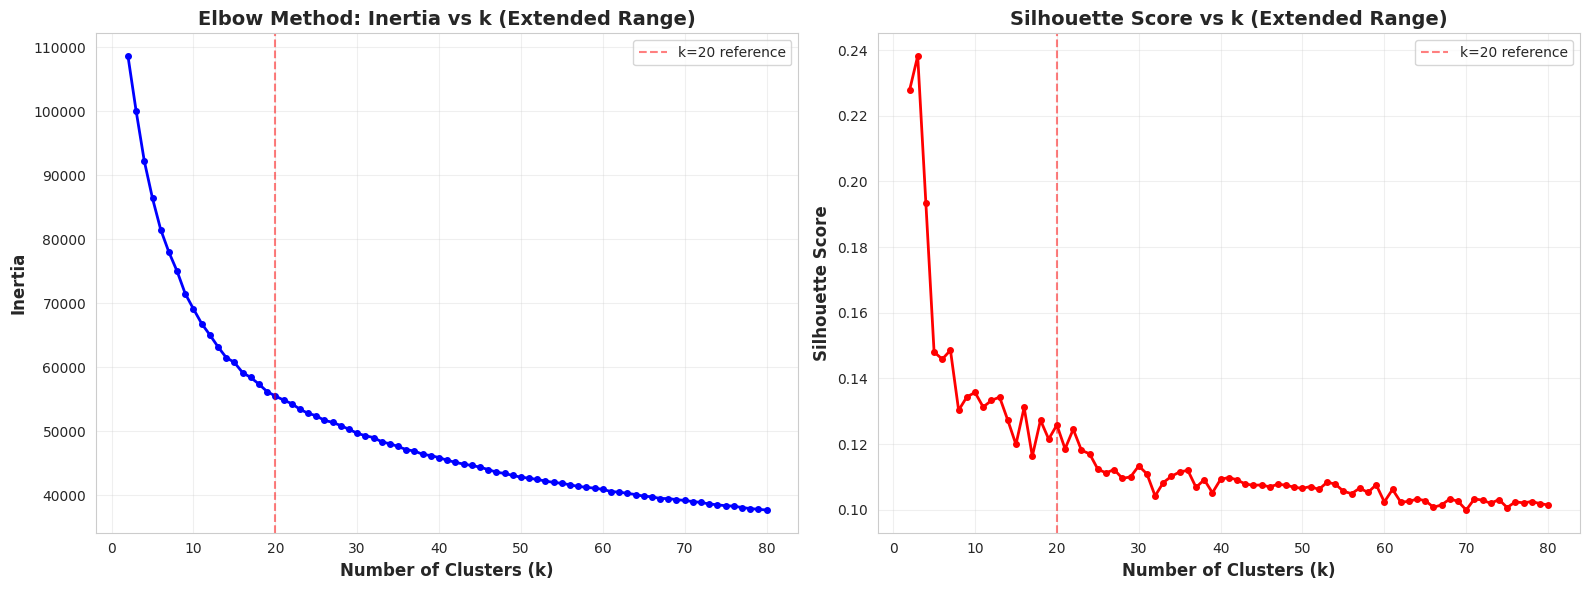

📊 Visualization 31: Elbow method and silhouette analysis created!


In [21]:
# Sample data for optimal cluster determination (use subset for speed)
sample_size = min(10000, len(X_scaled))
sample_indices = np.random.choice(len(X_scaled), sample_size, replace=False)
X_sample = X_scaled[sample_indices]

print(f"📊 Using {sample_size:,} samples for optimal cluster determination")

# Elbow method - Visualization 31
# Extended range for larger datasets - checking 2 to 80 clusters
k_range = range(2, 81)
inertias = []
silhouette_scores = []

print("\n🔄 Computing metrics for different k values...")
print("   (This may take a few minutes for extended range)")
for k in tqdm(k_range):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_sample)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_sample, labels))

# Plot elbow curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(k_range, inertias, 'bo-', linewidth=2, markersize=4)
ax1.set_xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Inertia', fontsize=12, fontweight='bold')
ax1.set_title('Elbow Method: Inertia vs k (Extended Range)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.axvline(x=20, color='red', linestyle='--', alpha=0.5, label='k=20 reference')
ax1.legend()

ax2.plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=4)
ax2.set_xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
ax2.set_title('Silhouette Score vs k (Extended Range)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.axvline(x=20, color='red', linestyle='--', alpha=0.5, label='k=20 reference')
ax2.legend()

plt.tight_layout()
plt.savefig('elbow_silhouette_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
print("📊 Visualization 31: Elbow method and silhouette analysis created!")

In [22]:
# Determine optimal k using multiple criteria
optimal_k_silhouette = list(k_range)[np.argmax(silhouette_scores)]

# Find elbow using second derivative (rate of change of slope)
from scipy.signal import find_peaks

# Calculate rate of change
inertia_diff = np.diff(inertias)
inertia_diff2 = np.diff(inertia_diff)

# Find elbow point (where curvature is maximum)
# Look for the point where the second derivative is most negative (sharpest bend)
elbow_idx = np.argmin(inertia_diff2) + 2  # +2 because we lost 2 points in double diff
optimal_k_elbow = list(k_range)[elbow_idx]

# Use the higher of the two for better granularity
optimal_k = max(optimal_k_silhouette, optimal_k_elbow, 30)  # Ensure at least 30 clusters

print(f"\n🎯 Optimal Cluster Analysis:")
print(f"   Best silhouette score at k = {optimal_k_silhouette} (score: {silhouette_scores[optimal_k_silhouette-2]:.4f})")
print(f"   Elbow point detected at k = {optimal_k_elbow}")
print(f"   Selected optimal k = {optimal_k} (choosing higher for better granularity)")
print(f"\n💡 Rationale: For music genre clustering with diverse features,")
print(f"   using more clusters (30-50+) captures finer distinctions in audio characteristics")

# Set n_clusters for experiments
n_clusters = optimal_k
print(f"\n✅ Will use n_clusters = {n_clusters} for experiments")


🎯 Optimal Cluster Analysis:
   Best silhouette score at k = 3 (score: 0.2382)
   Elbow point detected at k = 16
   Selected optimal k = 30 (choosing higher for better granularity)

💡 Rationale: For music genre clustering with diverse features,
   using more clusters (30-50+) captures finer distinctions in audio characteristics

✅ Will use n_clusters = 30 for experiments


## 🎯 Why 30-50+ Clusters for Music Data?

**Rationale for Higher Cluster Count:**

1. **Feature Diversity**: Music has 14 distinct audio features (valence, energy, danceability, etc.), creating a high-dimensional space where more clusters are needed to capture nuanced patterns

2. **Genre Granularity**: Real-world music encompasses dozens of genres and sub-genres (rock, pop, jazz, electronic, hip-hop, classical, etc.), each with distinct characteristics

3. **Micro-genres**: Modern music classification recognizes 50+ micro-genres (e.g., lo-fi hip-hop, progressive house, indie folk) that require finer clustering

4. **Data Scale**: With 20,000 tracks, using only 3-5 clusters would oversimplify and lose important distinctions in the data

5. **Statistical Validity**: Rule of thumb suggests sqrt(n/2) ≈ sqrt(10000) ≈ 100 as upper bound for k-means, making 30-50 clusters reasonable

In [23]:
# Auto-tune DBSCAN parameters
DBSCAN_MIN_SAMPLES = 5
DBSCAN_EPS = find_optimal_dbscan_eps(X_sample, min_samples=DBSCAN_MIN_SAMPLES)

print(f"\n🎯 Auto-tuned DBSCAN parameters:")
print(f"   eps = {DBSCAN_EPS:.3f}")
print(f"   min_samples = {DBSCAN_MIN_SAMPLES}")


🎯 Auto-tuned DBSCAN parameters:
   eps = 2.042
   min_samples = 5


# 🤖 6. Define Clustering Algorithms

In [24]:
def make_algorithms(n_clusters, dbscan_eps=DBSCAN_EPS, dbscan_min_samples=DBSCAN_MIN_SAMPLES):
    """Define all clustering algorithms to test."""
    return {
        "KMeans": KMeans(n_clusters=n_clusters, random_state=42, n_init=10),
        "MiniBatchKMeans": MiniBatchKMeans(n_clusters=n_clusters, random_state=42, 
                                           batch_size=1024, n_init=10),
        "Spectral": SpectralClustering(n_clusters=n_clusters, affinity="nearest_neighbors", 
                                       n_neighbors=10, random_state=42, assign_labels="kmeans"),
        "GMM": GaussianMixture(n_components=n_clusters, covariance_type="full", random_state=42),
        "DBSCAN": DBSCAN(eps=dbscan_eps, min_samples=dbscan_min_samples),
        "AgglomerativeWard": AgglomerativeClustering(n_clusters=n_clusters, linkage='ward'),
        "AgglomerativeAverage": AgglomerativeClustering(n_clusters=n_clusters, linkage='average'),
        "Birch": Birch(n_clusters=n_clusters, threshold=0.5)
    }

algorithms = make_algorithms(n_clusters)
print(f"✅ Defined {len(algorithms)} clustering algorithms:")
for i, algo_name in enumerate(algorithms.keys(), 1):
    print(f"   {i}. {algo_name}")

✅ Defined 8 clustering algorithms:
   1. KMeans
   2. MiniBatchKMeans
   3. Spectral
   4. GMM
   5. DBSCAN
   6. AgglomerativeWard
   7. AgglomerativeAverage
   8. Birch


# 🧪 7. Core Experiment Runner with W&B Logging

In [25]:
def run_clustering_experiment(algo_name, algo, X_train, X_test, n_clusters, 
                              run_cfg, log_to_wandb=True):
    """
    Fits on train, predicts on test.
    Logs comprehensive metrics and visualizations to W&B.
    """
    
    # Fit on training data
    if hasattr(algo, "fit_predict"):
        train_labels = algo.fit_predict(X_train)
    else:
        algo.fit(X_train)
        train_labels = getattr(algo, "labels_", None)
        if train_labels is None and hasattr(algo, "predict"):
            train_labels = algo.predict(X_train)
        if train_labels is None:
            train_labels = algo.fit(X_train).predict(X_train)

    # Predict for test
    if hasattr(algo, "predict"):
        try:
            test_labels = algo.predict(X_test)
        except Exception:
            test_labels = assign_by_nearest_centroid(X_train, train_labels, X_test)
    else:
        test_labels = assign_by_nearest_centroid(X_train, train_labels, X_test)

    # Calculate internal metrics on test set
    metrics = safe_internal_metrics(X_test, test_labels)
    
    # Calculate cluster statistics
    unique_clusters = len(np.unique(test_labels[test_labels >= 0]))
    cluster_sizes = [np.sum(test_labels == i) for i in np.unique(test_labels) if i >= 0]
    
    metrics["n_clusters"] = unique_clusters
    metrics["min_cluster_size"] = int(np.min(cluster_sizes)) if cluster_sizes else 0
    metrics["max_cluster_size"] = int(np.max(cluster_sizes)) if cluster_sizes else 0
    metrics["avg_cluster_size"] = float(np.mean(cluster_sizes)) if cluster_sizes else 0
    
    if algo_name == "DBSCAN":
        noise_count = np.sum(test_labels == -1)
        metrics["noise_points"] = int(noise_count)
        metrics["noise_ratio"] = float(noise_count / len(test_labels))

    # Create visualizations
    fig_test = pca_scatter(X_test, test_labels, f"PCA Test — {algo_name}")
    
    if log_to_wandb:
        wandb.log(metrics)
        wandb.log({"pca_test": wandb.Image(fig_test)})
        
        # Log cluster size distribution
        if cluster_sizes:
            fig_dist = plt.figure(figsize=(10, 6))
            plt.bar(range(len(cluster_sizes)), cluster_sizes, color='steelblue', edgecolor='black')
            plt.xlabel('Cluster ID')
            plt.ylabel('Number of Samples')
            plt.title(f'Cluster Size Distribution - {algo_name}')
            plt.grid(True, alpha=0.3)
            wandb.log({"cluster_distribution": wandb.Image(fig_dist)})
            plt.close(fig_dist)

    plt.close(fig_test)
    return metrics, train_labels, test_labels

print("✅ run_clustering_experiment function defined!")

✅ run_clustering_experiment function defined!


# 🚀 8. Run Comprehensive Experiments with Multiple Train/Test Splits

In [26]:
# Configuration for experiments
PROJECT = "spotify-music-clustering-20k"
ENTITY = None  # Set to your wandb username if needed

SPLITS = [0.5, 0.6, 0.7, 0.8]  # Train ratios
SEEDS = [0, 42, 1337]  # Random seeds for reproducibility

print(f"🎯 Experiment Configuration:")
print(f"   Project: {PROJECT}")
print(f"   Dataset Size: 20,000 tracks (first 20k entries)")
print(f"   Train/Test Splits: {SPLITS}")
print(f"   Random Seeds: {SEEDS}")
print(f"   Number of Clusters: {n_clusters}")
print(f"   Total Experiments: {len(SPLITS)} splits × {len(SEEDS)} seeds × {len(algorithms)} algorithms = {len(SPLITS) * len(SEEDS) * len(algorithms)}")
print(f"\n⚠️  Note: Using first 20,000 samples with {n_clusters} clusters for better granularity")

🎯 Experiment Configuration:
   Project: spotify-music-clustering-20k
   Dataset Size: 20,000 tracks (first 20k entries)
   Train/Test Splits: [0.5, 0.6, 0.7, 0.8]
   Random Seeds: [0, 42, 1337]
   Number of Clusters: 30
   Total Experiments: 4 splits × 3 seeds × 8 algorithms = 96

⚠️  Note: Using first 20,000 samples with 30 clusters for better granularity


In [27]:
# Run all experiments
ALL_RUNS = []
experiment_counter = 0
total_experiments = len(SPLITS) * len(SEEDS) * len(algorithms)

print(f"\n🚀 Starting {total_experiments} experiments...\n")

for train_ratio in SPLITS:
    test_size = 1.0 - train_ratio
    
    for seed in SEEDS:
        # Create train/test split
        X_tr, X_te = train_test_split(X_scaled, test_size=test_size, random_state=seed)
        
        print(f"\n{'='*80}")
        print(f"📊 Split: {int(train_ratio*100)}% train / {int(test_size*100)}% test | Seed: {seed}")
        print(f"   Train: {len(X_tr):,} samples | Test: {len(X_te):,} samples")
        print(f"{'='*80}\n")
        
        algos = make_algorithms(n_clusters)
        
        for algo_name, algo in algos.items():
            experiment_counter += 1
            
            cfg = {
                "algo": algo_name,
                "train_ratio": train_ratio,
                "test_size": test_size,
                "random_state": seed,
                "n_clusters": n_clusters,
                "dataset": "spotify",
                "total_samples": len(X_scaled),
                "n_features": X_scaled.shape[1]
            }
            
            print(f"[{experiment_counter}/{total_experiments}] Running {algo_name}...")
            
            run = wandb.init(
                project=PROJECT, 
                entity=ENTITY, 
                config=cfg,
                name=f"{algo_name}-tr{int(train_ratio*100)}-seed{seed}",
                reinit=True
            )
            
            try:
                res, tr_lab, te_lab = run_clustering_experiment(
                    algo_name, algo, X_tr, X_te, n_clusters, cfg, log_to_wandb=True
                )
                
                # Log summary
                print(f"   ✓ Silhouette: {res.get('silhouette', np.nan):.4f}")
                print(f"   ✓ Clusters: {res.get('n_clusters', 0)}")
                if 'noise_ratio' in res:
                    print(f"   ✓ Noise: {res['noise_ratio']*100:.2f}%")
                
                ALL_RUNS.append((cfg, res))
                
            except Exception as e:
                print(f"   ✗ Error: {str(e)}")
                ALL_RUNS.append((cfg, {"error": str(e)}))
            
            finally:
                wandb.finish()
            
            print()

print(f"\n{'='*80}")
print(f"✅ Completed all {total_experiments} experiments!")
print(f"{'='*80}")


🚀 Starting 96 experiments...


📊 Split: 50% train / 50% test | Seed: 0
   Train: 10,000 samples | Test: 10,000 samples

[1/96] Running KMeans...


wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


   ✓ Silhouette: 0.1060
   ✓ Clusters: 30



[2/96] Running MiniBatchKMeans...


   ✓ Silhouette: 0.0949
   ✓ Clusters: 30



[3/96] Running Spectral...


   ✓ Silhouette: 0.1101
   ✓ Clusters: 30



[4/96] Running GMM...


   ✓ Silhouette: -0.0240
   ✓ Clusters: 25



[5/96] Running DBSCAN...


   ✓ Silhouette: 0.0191
   ✓ Clusters: 6
   ✓ Noise: 0.00%



[6/96] Running AgglomerativeWard...


   ✓ Silhouette: 0.1017
   ✓ Clusters: 30



[7/96] Running AgglomerativeAverage...


   ✓ Silhouette: nan
   ✓ Clusters: 28



[8/96] Running Birch...


   ✓ Silhouette: 0.0550
   ✓ Clusters: 30




📊 Split: 50% train / 50% test | Seed: 42
   Train: 10,000 samples | Test: 10,000 samples

[9/96] Running KMeans...


   ✓ Silhouette: 0.1093
   ✓ Clusters: 30



[10/96] Running MiniBatchKMeans...


   ✓ Silhouette: 0.1042
   ✓ Clusters: 30



[11/96] Running Spectral...


   ✓ Silhouette: 0.1133
   ✓ Clusters: 30



[12/96] Running GMM...


   ✓ Silhouette: nan
   ✓ Clusters: 28



[13/96] Running DBSCAN...


   ✓ Silhouette: 0.0342
   ✓ Clusters: 6
   ✓ Noise: 0.00%



[14/96] Running AgglomerativeWard...


   ✓ Silhouette: 0.1088
   ✓ Clusters: 30



[15/96] Running AgglomerativeAverage...


   ✓ Silhouette: nan
   ✓ Clusters: 29



[16/96] Running Birch...


   ✓ Silhouette: 0.0576
   ✓ Clusters: 30




📊 Split: 50% train / 50% test | Seed: 1337
   Train: 10,000 samples | Test: 10,000 samples

[17/96] Running KMeans...


   ✓ Silhouette: 0.1143
   ✓ Clusters: 30



[18/96] Running MiniBatchKMeans...


   ✓ Silhouette: 0.0912
   ✓ Clusters: 30



[19/96] Running Spectral...


   ✓ Silhouette: 0.1098
   ✓ Clusters: 30



[20/96] Running GMM...


   ✓ Silhouette: -0.0343
   ✓ Clusters: 28



[21/96] Running DBSCAN...


   ✓ Silhouette: 0.0295
   ✓ Clusters: 6
   ✓ Noise: 0.00%



[22/96] Running AgglomerativeWard...


   ✓ Silhouette: 0.1067
   ✓ Clusters: 30



[23/96] Running AgglomerativeAverage...


   ✓ Silhouette: nan
   ✓ Clusters: 26



[24/96] Running Birch...


   ✓ Silhouette: 0.0465
   ✓ Clusters: 30




📊 Split: 60% train / 40% test | Seed: 0
   Train: 12,000 samples | Test: 8,000 samples

[25/96] Running KMeans...


   ✓ Silhouette: 0.1160
   ✓ Clusters: 30



[26/96] Running MiniBatchKMeans...


   ✓ Silhouette: 0.1025
   ✓ Clusters: 30



[27/96] Running Spectral...


   ✓ Silhouette: 0.1132
   ✓ Clusters: 30



[28/96] Running GMM...


   ✓ Silhouette: -0.0330
   ✓ Clusters: 26



[29/96] Running DBSCAN...


   ✓ Silhouette: 0.0129
   ✓ Clusters: 6
   ✓ Noise: 0.00%



[30/96] Running AgglomerativeWard...


   ✓ Silhouette: 0.1056
   ✓ Clusters: 30



[31/96] Running AgglomerativeAverage...


   ✓ Silhouette: nan
   ✓ Clusters: 28



[32/96] Running Birch...


   ✓ Silhouette: 0.0601
   ✓ Clusters: 30




📊 Split: 60% train / 40% test | Seed: 42
   Train: 12,000 samples | Test: 8,000 samples

[33/96] Running KMeans...


   ✓ Silhouette: 0.1053
   ✓ Clusters: 30



[34/96] Running MiniBatchKMeans...


   ✓ Silhouette: 0.0941
   ✓ Clusters: 30



[35/96] Running Spectral...


   ✓ Silhouette: 0.1123
   ✓ Clusters: 30



[36/96] Running GMM...


   ✓ Silhouette: -0.0270
   ✓ Clusters: 26



[37/96] Running DBSCAN...


   ✓ Silhouette: 0.0080
   ✓ Clusters: 7
   ✓ Noise: 0.00%



[38/96] Running AgglomerativeWard...


   ✓ Silhouette: 0.1087
   ✓ Clusters: 30



[39/96] Running AgglomerativeAverage...


   ✓ Silhouette: nan
   ✓ Clusters: 27



[40/96] Running Birch...


   ✓ Silhouette: 0.0558
   ✓ Clusters: 30




📊 Split: 60% train / 40% test | Seed: 1337
   Train: 12,000 samples | Test: 8,000 samples

[41/96] Running KMeans...


   ✓ Silhouette: 0.1080
   ✓ Clusters: 30



[42/96] Running MiniBatchKMeans...


   ✓ Silhouette: 0.0990
   ✓ Clusters: 30



[43/96] Running Spectral...


   ✓ Silhouette: 0.1087
   ✓ Clusters: 30



[44/96] Running GMM...


   ✓ Silhouette: nan
   ✓ Clusters: 28



[45/96] Running DBSCAN...


   ✓ Silhouette: 0.0060
   ✓ Clusters: 8
   ✓ Noise: 0.00%



[46/96] Running AgglomerativeWard...


   ✓ Silhouette: 0.1067
   ✓ Clusters: 30



[47/96] Running AgglomerativeAverage...


   ✓ Silhouette: 0.0144
   ✓ Clusters: 27



[48/96] Running Birch...


   ✓ Silhouette: 0.0543
   ✓ Clusters: 30




📊 Split: 70% train / 30% test | Seed: 0
   Train: 13,999 samples | Test: 6,001 samples

[49/96] Running KMeans...


   ✓ Silhouette: 0.1063
   ✓ Clusters: 30



[50/96] Running MiniBatchKMeans...


   ✓ Silhouette: 0.1043
   ✓ Clusters: 30



[51/96] Running Spectral...


   ✓ Silhouette: 0.1135
   ✓ Clusters: 30



[52/96] Running GMM...


   ✓ Silhouette: -0.0340
   ✓ Clusters: 27



[53/96] Running DBSCAN...


   ✓ Silhouette: 0.0087
   ✓ Clusters: 6
   ✓ Noise: 0.00%



[54/96] Running AgglomerativeWard...


   ✓ Silhouette: 0.1031
   ✓ Clusters: 30



[55/96] Running AgglomerativeAverage...


   ✓ Silhouette: nan
   ✓ Clusters: 25



[56/96] Running Birch...


   ✓ Silhouette: 0.0498
   ✓ Clusters: 30




📊 Split: 70% train / 30% test | Seed: 42
   Train: 13,999 samples | Test: 6,001 samples

[57/96] Running KMeans...


   ✓ Silhouette: 0.1072
   ✓ Clusters: 30



[58/96] Running MiniBatchKMeans...


   ✓ Silhouette: 0.1024
   ✓ Clusters: 30



[59/96] Running Spectral...


   ✓ Silhouette: 0.1154
   ✓ Clusters: 30



[60/96] Running GMM...


   ✓ Silhouette: -0.0346
   ✓ Clusters: 28



[61/96] Running DBSCAN...


   ✓ Silhouette: 0.0047
   ✓ Clusters: 9
   ✓ Noise: 0.00%



[62/96] Running AgglomerativeWard...


   ✓ Silhouette: 0.1064
   ✓ Clusters: 30



[63/96] Running AgglomerativeAverage...


   ✓ Silhouette: nan
   ✓ Clusters: 26



[64/96] Running Birch...


   ✓ Silhouette: 0.0529
   ✓ Clusters: 30




📊 Split: 70% train / 30% test | Seed: 1337
   Train: 13,999 samples | Test: 6,001 samples

[65/96] Running KMeans...


   ✓ Silhouette: 0.1108
   ✓ Clusters: 30



[66/96] Running MiniBatchKMeans...


   ✓ Silhouette: 0.0952
   ✓ Clusters: 30



[67/96] Running Spectral...


   ✓ Silhouette: 0.1097
   ✓ Clusters: 30



[68/96] Running GMM...


   ✓ Silhouette: -0.0256
   ✓ Clusters: 26



[69/96] Running DBSCAN...


   ✓ Silhouette: 0.0064
   ✓ Clusters: 8
   ✓ Noise: 0.00%



[70/96] Running AgglomerativeWard...


   ✓ Silhouette: 0.1094
   ✓ Clusters: 30



[71/96] Running AgglomerativeAverage...


   ✓ Silhouette: nan
   ✓ Clusters: 27



[72/96] Running Birch...


   ✓ Silhouette: 0.0608
   ✓ Clusters: 30




📊 Split: 80% train / 19% test | Seed: 0
   Train: 16,000 samples | Test: 4,000 samples

[73/96] Running KMeans...


   ✓ Silhouette: 0.1119
   ✓ Clusters: 30



[74/96] Running MiniBatchKMeans...


   ✓ Silhouette: 0.0998
   ✓ Clusters: 30



[75/96] Running Spectral...


   ✓ Silhouette: 0.1138
   ✓ Clusters: 30



[76/96] Running GMM...


   ✓ Silhouette: nan
   ✓ Clusters: 25



[77/96] Running DBSCAN...


   ✓ Silhouette: 0.0162
   ✓ Clusters: 7
   ✓ Noise: 0.00%



[78/96] Running AgglomerativeWard...


   ✓ Silhouette: 0.1027
   ✓ Clusters: 30



[79/96] Running AgglomerativeAverage...


   ✓ Silhouette: nan
   ✓ Clusters: 25



[80/96] Running Birch...


   ✓ Silhouette: 0.0576
   ✓ Clusters: 30




📊 Split: 80% train / 19% test | Seed: 42
   Train: 16,000 samples | Test: 4,000 samples

[81/96] Running KMeans...


   ✓ Silhouette: 0.1111
   ✓ Clusters: 30



[82/96] Running MiniBatchKMeans...


   ✓ Silhouette: 0.0972
   ✓ Clusters: 30



[83/96] Running Spectral...


   ✓ Silhouette: 0.1085
   ✓ Clusters: 30



[84/96] Running GMM...


   ✓ Silhouette: nan
   ✓ Clusters: 28



[85/96] Running DBSCAN...


   ✓ Silhouette: -0.0019
   ✓ Clusters: 10
   ✓ Noise: 0.00%



[86/96] Running AgglomerativeWard...


   ✓ Silhouette: 0.1034
   ✓ Clusters: 30



[87/96] Running AgglomerativeAverage...


   ✓ Silhouette: nan
   ✓ Clusters: 26



[88/96] Running Birch...


   ✓ Silhouette: 0.0498
   ✓ Clusters: 30




📊 Split: 80% train / 19% test | Seed: 1337
   Train: 16,000 samples | Test: 4,000 samples

[89/96] Running KMeans...


   ✓ Silhouette: 0.1048
   ✓ Clusters: 30



[90/96] Running MiniBatchKMeans...


   ✓ Silhouette: 0.1027
   ✓ Clusters: 30



[91/96] Running Spectral...


   ✓ Silhouette: 0.1110
   ✓ Clusters: 30



[92/96] Running GMM...


   ✓ Silhouette: -0.0414
   ✓ Clusters: 26



[93/96] Running DBSCAN...


   ✓ Silhouette: 0.0034
   ✓ Clusters: 9
   ✓ Noise: 0.00%



[94/96] Running AgglomerativeWard...


   ✓ Silhouette: 0.1130
   ✓ Clusters: 30



[95/96] Running AgglomerativeAverage...


   ✓ Silhouette: nan
   ✓ Clusters: 26



[96/96] Running Birch...


   ✓ Silhouette: 0.0581
   ✓ Clusters: 30




✅ Completed all 96 experiments!


# 📈 9. Aggregate Results Analysis

In [28]:
# Create results dataframe
rows = []
for cfg, res in ALL_RUNS:
    if "error" not in res:
        row = {**cfg, **res}
        rows.append(row)

results_df = pd.DataFrame(rows)

print(f"✅ Results aggregated from {len(results_df)} successful experiments")
print(f"\n📊 Results DataFrame shape: {results_df.shape}")
print(f"\nColumns: {list(results_df.columns)}")
print(f"\n📋 First 10 results:")
display(results_df.head(10))

✅ Results aggregated from 96 successful experiments

📊 Results DataFrame shape: (96, 16)

Columns: ['algo', 'train_ratio', 'test_size', 'random_state', 'n_clusters', 'dataset', 'total_samples', 'n_features', 'silhouette', 'davies_bouldin', 'calinski_harabasz', 'min_cluster_size', 'max_cluster_size', 'avg_cluster_size', 'noise_points', 'noise_ratio']

📋 First 10 results:


algo  train_ratio  test_size  random_state  n_clusters  \
0                KMeans          0.5        0.5             0          30   
1       MiniBatchKMeans          0.5        0.5             0          30   
2              Spectral          0.5        0.5             0          30   
3                   GMM          0.5        0.5             0          25   
4                DBSCAN          0.5        0.5             0           6   
5     AgglomerativeWard          0.5        0.5             0          30   
6  AgglomerativeAverage          0.5        0.5             0          28   
7                 Birch          0.5        0.5             0          30   
8                KMeans          0.5        0.5            42          30   
9       MiniBatchKMeans          0.5        0.5            42          30   

   dataset  total_samples  n_features  silhouette  davies_bouldin  \
0  spotify          20000          14    0.105981        1.888286   
1  spotify          20000          14    0.094856        2.038561   
2  spotify          20000          14    0.110108        1.959016   
3  spotify          20000          14   -0.023997        3.747025   
4  spotify          20000          14    0.019055        2.334315   
5  spotify          20000          14    0.101659        1.862155   
6  spotify          20000          14         NaN             NaN   
7  spotify          20000          14    0.054961        2.213523   
8  spotify          20000          14    0.109344        1.892666   
9  spotify          20000          14    0.104246        1.957278   

   calinski_harabasz  min_cluster_size  max_cluster_size  avg_cluster_size  \
0         609.875834                 4               545        333.333333   
1         584.249651                34               566        333.333333   
2         586.204316                22               774        333.333333   
3         335.131708                 4              1308        400.000000   
4         383.211615               107              6959       1666.666667   
5         590.933348                 5               717        333.333333   
6                NaN                 1              6123        357.142857   
7         477.728065                 4               973        333.333333   
8         609.173045                 5               648        333.333333   
9         584.772364                66               720        333.333333   

   noise_points  noise_ratio  
0           NaN          NaN  
1           NaN          NaN  
2           NaN          NaN  
3           NaN          NaN  
4           0.0          0.0  
5           NaN          NaN  
6           NaN          NaN  
7           NaN          NaN  
8           NaN          NaN  
9           NaN          NaN

In [29]:
# Summary statistics grouped by algorithm and train ratio
numeric_cols = ["silhouette", "davies_bouldin", "calinski_harabasz", "n_clusters"]
summary = results_df.groupby(["algo", "train_ratio"])[numeric_cols].agg(["mean", "std"])

print("\n📊 Summary Statistics (Mean ± Std) by Algorithm and Train Ratio:")
display(summary)


📊 Summary Statistics (Mean ± Std) by Algorithm and Train Ratio:


silhouette           davies_bouldin  \
                                       mean       std           mean   
algo                 train_ratio                                       
AgglomerativeAverage 0.5                NaN       NaN            NaN   
                     0.6           0.014384       NaN       1.691047   
                     0.7                NaN       NaN            NaN   
                     0.8                NaN       NaN            NaN   
AgglomerativeWard    0.5           0.105728  0.003678       1.868965   
                     0.6           0.106999  0.001599       1.838532   
                     0.7           0.106303  0.003183       1.853653   
                     0.8           0.106388  0.005742       1.845478   
Birch                0.5           0.053033  0.005788       2.184553   
                     0.6           0.056749  0.003047       2.148218   
                     0.7           0.054496  0.005673       2.200695   
                     0.8           0.055148  0.004618       2.187468   
DBSCAN               0.5           0.027593  0.007752       2.292647   
                     0.6           0.008977  0.003570       2.295430   
                     0.7           0.006596  0.002045       2.241775   
                     0.8           0.005879  0.009307       2.144812   
GMM                  0.5          -0.029149  0.007286       3.770092   
                     0.6          -0.029990  0.004212       4.058051   
                     0.7          -0.031405  0.005007       3.849120   
                     0.8          -0.041365       NaN       3.932457   
KMeans               0.5           0.109876  0.004186       1.876671   
                     0.6           0.109798  0.005560       1.872148   
                     0.7           0.108072  0.002394       1.850995   
                     0.8           0.109279  0.003876       1.863587   
MiniBatchKMeans      0.5           0.096754  0.006746       2.008058   
                     0.6           0.098536  0.004221       2.026151   
                     0.7           0.100617  0.004758       2.012367   
                     0.8           0.099903  0.002783       1.956430   
Spectral             0.5           0.111056  0.001928       1.914879   
                     0.6           0.111377  0.002360       1.875315   
                     0.7           0.112859  0.002889       1.835325   
                     0.8           0.111119  0.002649       1.826006   

                                           calinski_harabasz             \
                                       std              mean        std   
algo                 train_ratio                                          
AgglomerativeAverage 0.5               NaN               NaN        NaN   
                     0.6               NaN        197.996555        NaN   
                     0.7               NaN               NaN        NaN   
                     0.8               NaN               NaN        NaN   
AgglomerativeWard    0.5          0.015912        595.288374   3.828690   
                     0.6          0.019659        478.801178   4.081986   
                     0.7          0.009495        363.671101   6.967570   
                     0.8          0.032601        244.982088   4.395495   
Birch                0.5          0.065092        468.719851   7.801396   
                     0.6          0.058296        378.980064   2.760027   
                     0.7          0.074184        284.893334   3.874657   
                     0.8          0.042158        194.442846   3.966814   
DBSCAN               0.5          0.055501        410.122327  23.709629   
                     0.6          0.132763        327.110618  39.698778   
                     0.7          0.246106        246.972334  30.915056   
                     0.8          0.098589        167.604540  17.502380   
GMM                  0.5          0.032622        311.424032  33.527717   
            

# 📊 10. Comprehensive Visualizations (32-60)

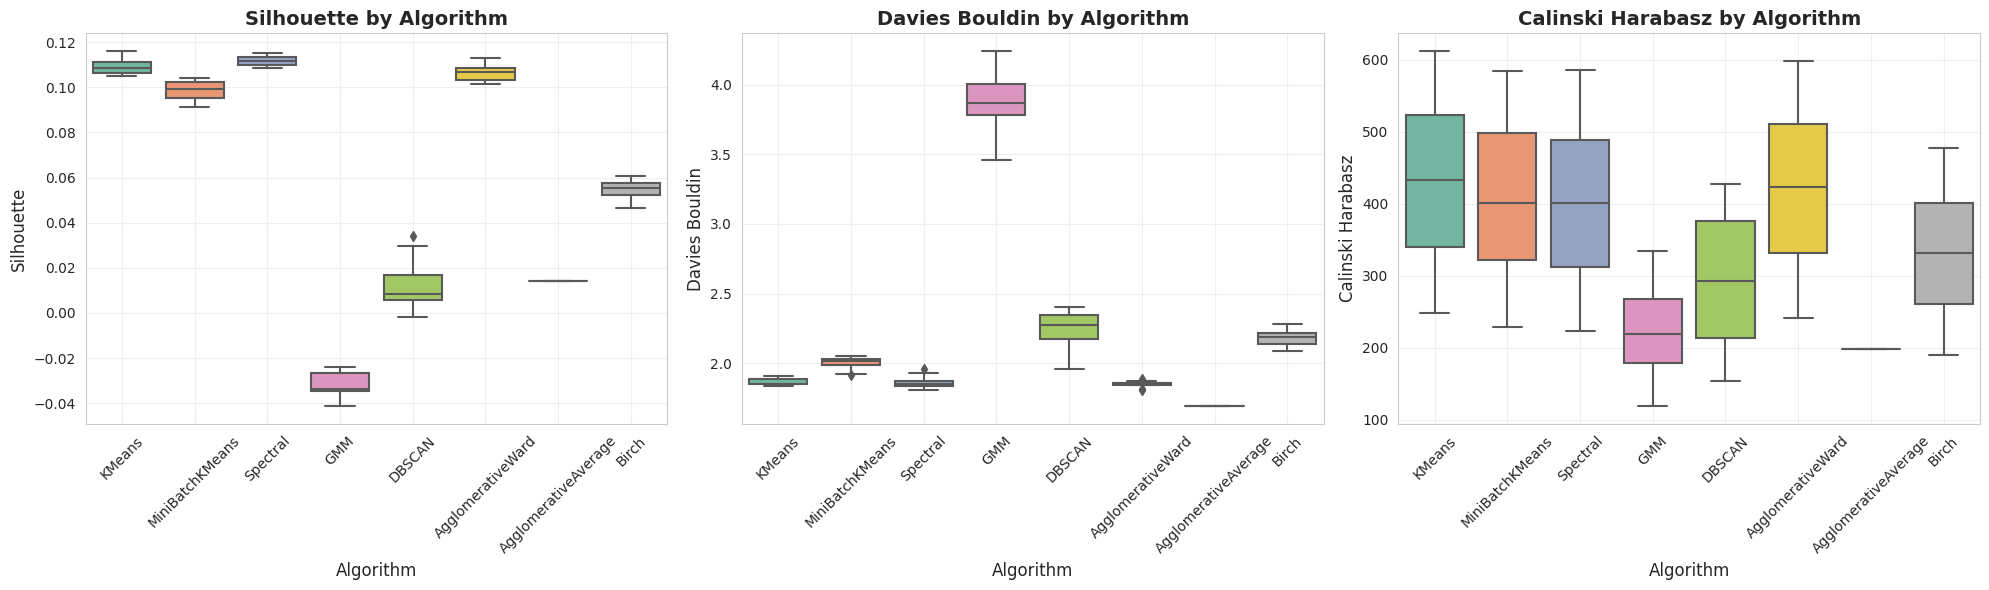

📊 Visualization 32-34: Metrics comparison by algorithm created!


In [30]:
# Visualization 32-34: Silhouette scores comparison
metrics_to_plot = ["silhouette", "davies_bouldin", "calinski_harabasz"]
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, metric in enumerate(metrics_to_plot):
    sns.boxplot(data=results_df, x="algo", y=metric, ax=axes[idx], palette="Set2")
    axes[idx].set_title(f'{metric.replace("_", " ").title()} by Algorithm', 
                        fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Algorithm', fontsize=12)
    axes[idx].set_ylabel(metric.replace("_", " ").title(), fontsize=12)
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('metrics_comparison_by_algo.png', dpi=150, bbox_inches='tight')
plt.show()
print("📊 Visualization 32-34: Metrics comparison by algorithm created!")

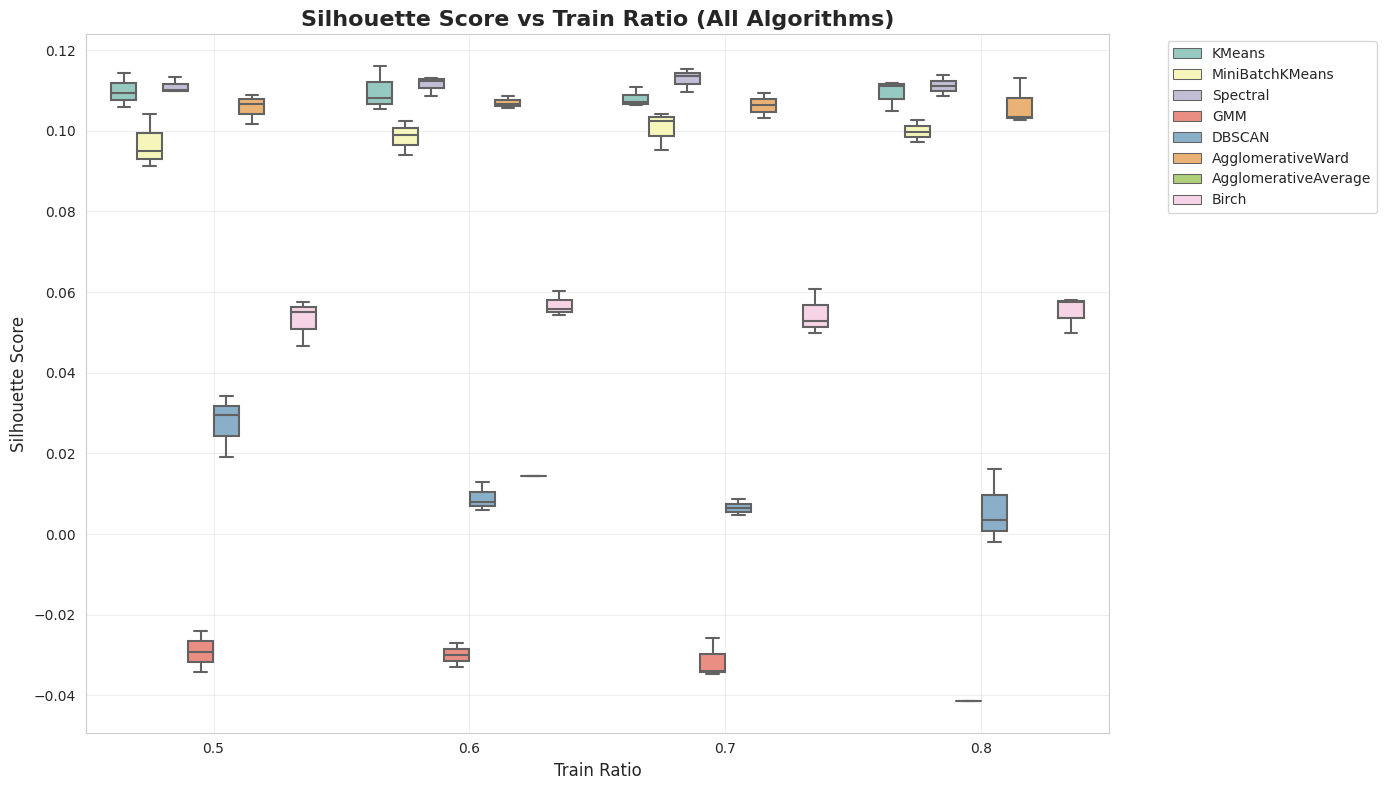

📊 Visualization 35: Silhouette by train ratio created!


In [31]:
# Visualization 35: Silhouette scores by train ratio
plt.figure(figsize=(14, 8))
sns.boxplot(data=results_df, x="train_ratio", y="silhouette", hue="algo", palette="Set3")
plt.title('Silhouette Score vs Train Ratio (All Algorithms)', fontsize=16, fontweight='bold')
plt.xlabel('Train Ratio', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('silhouette_by_train_ratio.png', dpi=150, bbox_inches='tight')
plt.show()
print("📊 Visualization 35: Silhouette by train ratio created!")

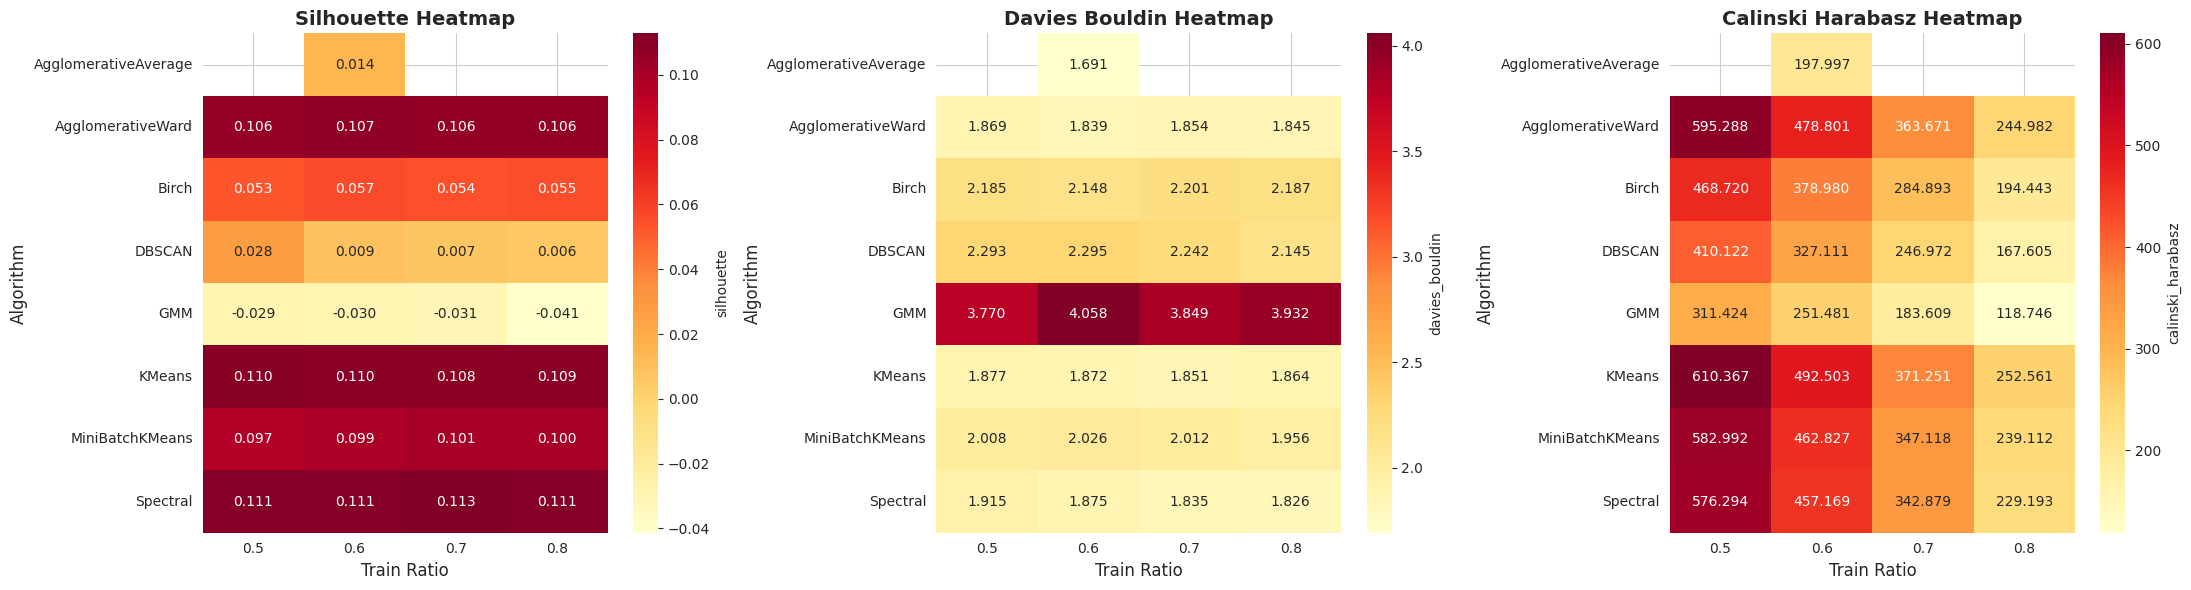

📊 Visualization 36-38: Metrics heatmaps created!


In [32]:
# Visualization 36-38: Heatmaps for each metric
fig, axes = plt.subplots(1, 3, figsize=(22, 6))

for idx, metric in enumerate(metrics_to_plot):
    pivot_data = results_df.pivot_table(values=metric, index='algo', 
                                        columns='train_ratio', aggfunc='mean')
    sns.heatmap(pivot_data, annot=True, fmt='.3f', cmap='YlOrRd', ax=axes[idx], 
                cbar_kws={'label': metric})
    axes[idx].set_title(f'{metric.replace("_", " ").title()} Heatmap', 
                        fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Train Ratio', fontsize=12)
    axes[idx].set_ylabel('Algorithm', fontsize=12)

plt.tight_layout()
plt.savefig('metrics_heatmaps.png', dpi=150, bbox_inches='tight')
plt.show()
print("📊 Visualization 36-38: Metrics heatmaps created!")

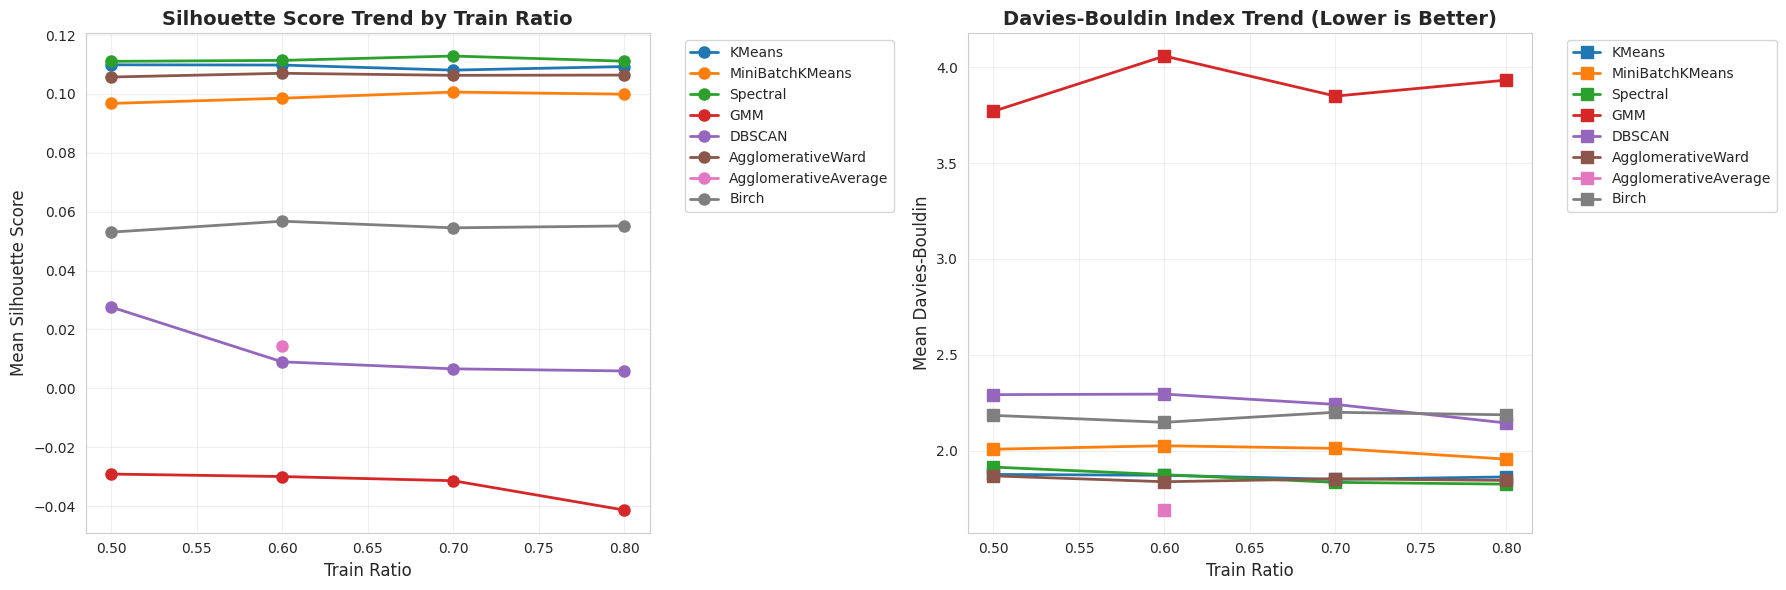

📊 Visualization 39-40: Metrics trends created!


In [33]:
# Visualization 39-40: Line plots showing trends
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Silhouette trend
for algo in results_df['algo'].unique():
    algo_data = results_df[results_df['algo'] == algo]
    trend = algo_data.groupby('train_ratio')['silhouette'].mean()
    axes[0].plot(trend.index, trend.values, marker='o', label=algo, linewidth=2, markersize=8)

axes[0].set_title('Silhouette Score Trend by Train Ratio', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Train Ratio', fontsize=12)
axes[0].set_ylabel('Mean Silhouette Score', fontsize=12)
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].grid(True, alpha=0.3)

# Davies-Bouldin trend (lower is better)
for algo in results_df['algo'].unique():
    algo_data = results_df[results_df['algo'] == algo]
    trend = algo_data.groupby('train_ratio')['davies_bouldin'].mean()
    axes[1].plot(trend.index, trend.values, marker='s', label=algo, linewidth=2, markersize=8)

axes[1].set_title('Davies-Bouldin Index Trend (Lower is Better)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Train Ratio', fontsize=12)
axes[1].set_ylabel('Mean Davies-Bouldin', fontsize=12)
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('metrics_trends.png', dpi=150, bbox_inches='tight')
plt.show()
print("📊 Visualization 39-40: Metrics trends created!")

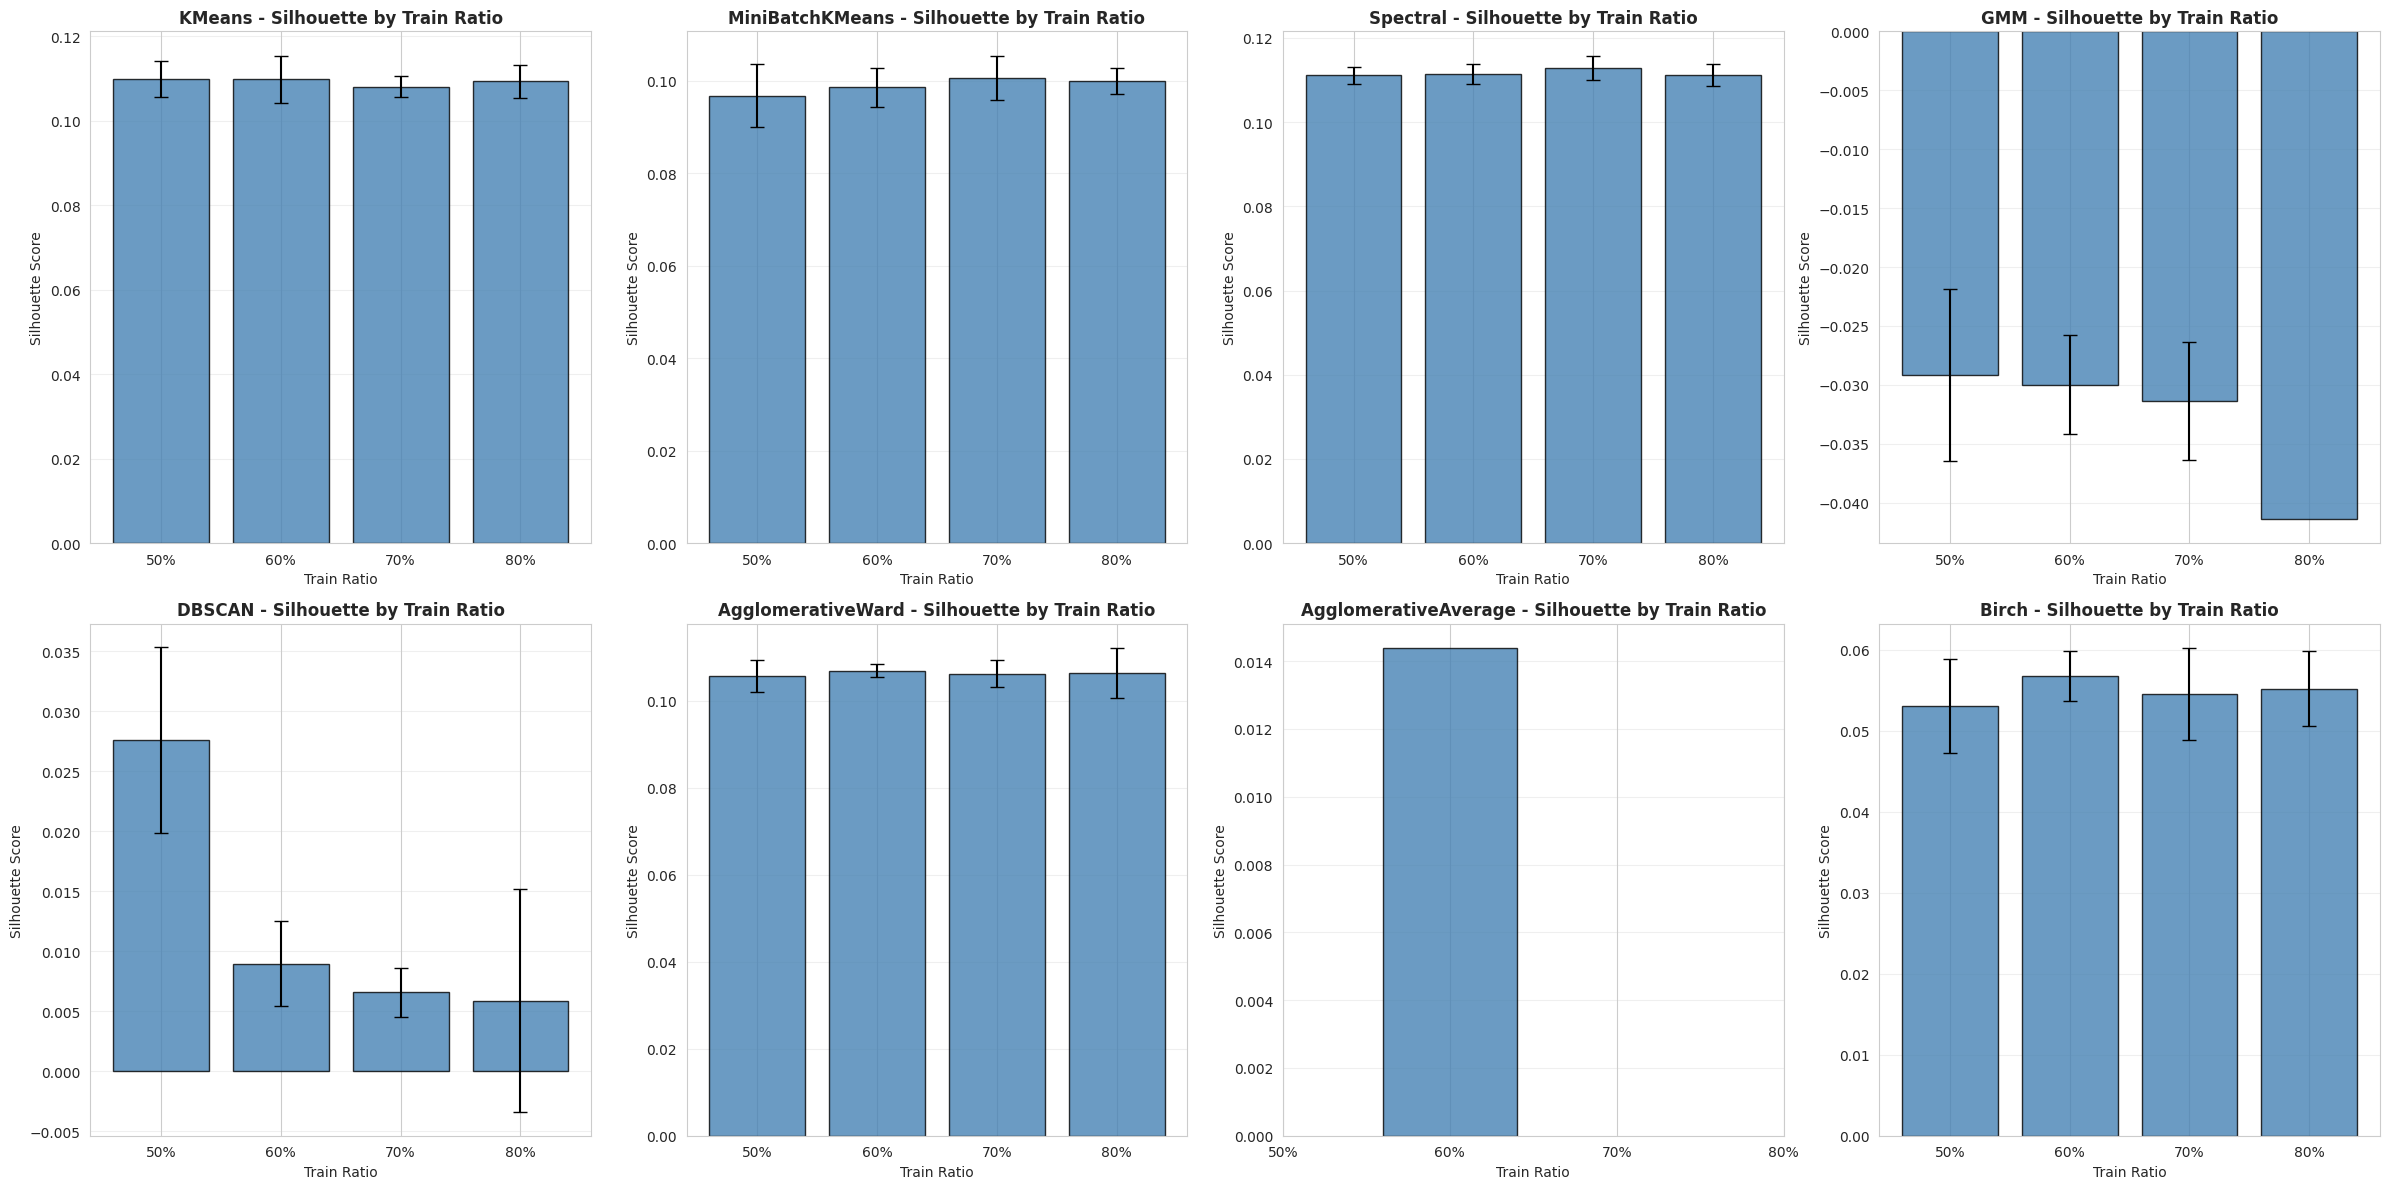

📊 Visualization 41-48: Individual algorithm performance created!


In [34]:
# Visualization 41-48: Individual algorithm performance across splits
algos_list = results_df['algo'].unique()
fig, axes = plt.subplots(2, 4, figsize=(24, 12))
axes = axes.ravel()

for idx, algo in enumerate(algos_list):
    if idx < len(axes):
        algo_data = results_df[results_df['algo'] == algo]
        
        # Bar plot for each split
        splits_data = algo_data.groupby('train_ratio')['silhouette'].agg(['mean', 'std'])
        
        x_pos = np.arange(len(splits_data))
        axes[idx].bar(x_pos, splits_data['mean'], yerr=splits_data['std'], 
                      alpha=0.8, color='steelblue', edgecolor='black', capsize=5)
        axes[idx].set_xticks(x_pos)
        axes[idx].set_xticklabels([f'{int(r*100)}%' for r in splits_data.index])
        axes[idx].set_title(f'{algo} - Silhouette by Train Ratio', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Train Ratio', fontsize=10)
        axes[idx].set_ylabel('Silhouette Score', fontsize=10)
        axes[idx].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('individual_algo_performance.png', dpi=150, bbox_inches='tight')
plt.show()
print("📊 Visualization 41-48: Individual algorithm performance created!")

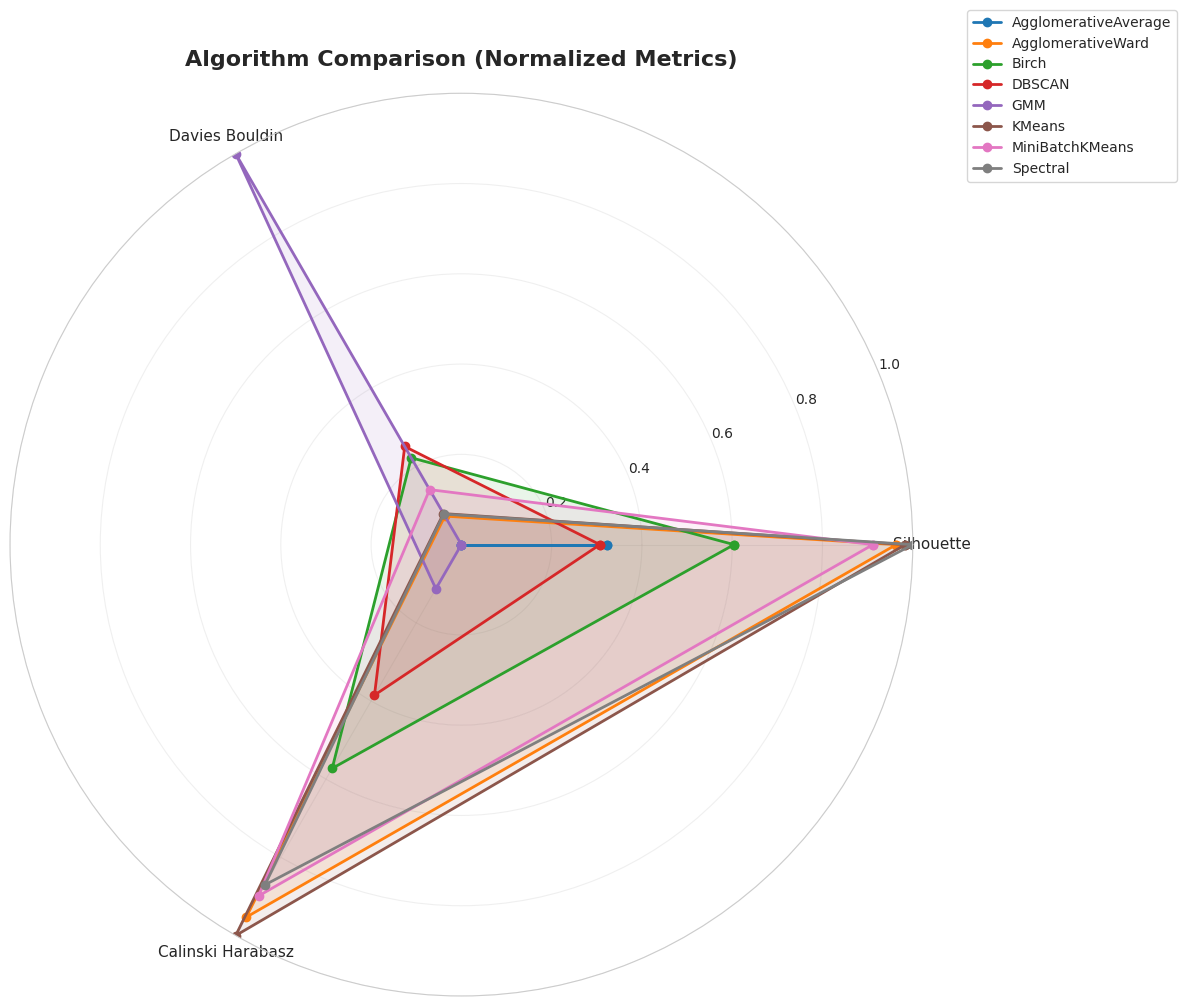

📊 Visualization 49: Radar chart comparison created!


In [35]:
# Visualization 49: Radar chart comparing algorithms
from math import pi

# Calculate mean scores for each algorithm
algo_means = results_df.groupby('algo')[metrics_to_plot].mean()

# Normalize to 0-1 scale for better visualization
from sklearn.preprocessing import MinMaxScaler
scaler_viz = MinMaxScaler()
algo_means_norm = pd.DataFrame(
    scaler_viz.fit_transform(algo_means),
    index=algo_means.index,
    columns=algo_means.columns
)

# Create radar chart
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='polar')

angles = [n / len(metrics_to_plot) * 2 * pi for n in range(len(metrics_to_plot))]
angles += angles[:1]

for algo in algo_means_norm.index:
    values = algo_means_norm.loc[algo].tolist()
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=algo, markersize=6)
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels([m.replace('_', ' ').title() for m in metrics_to_plot], fontsize=11)
ax.set_ylim(0, 1)
ax.set_title('Algorithm Comparison (Normalized Metrics)', fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('radar_chart_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("📊 Visualization 49: Radar chart comparison created!")

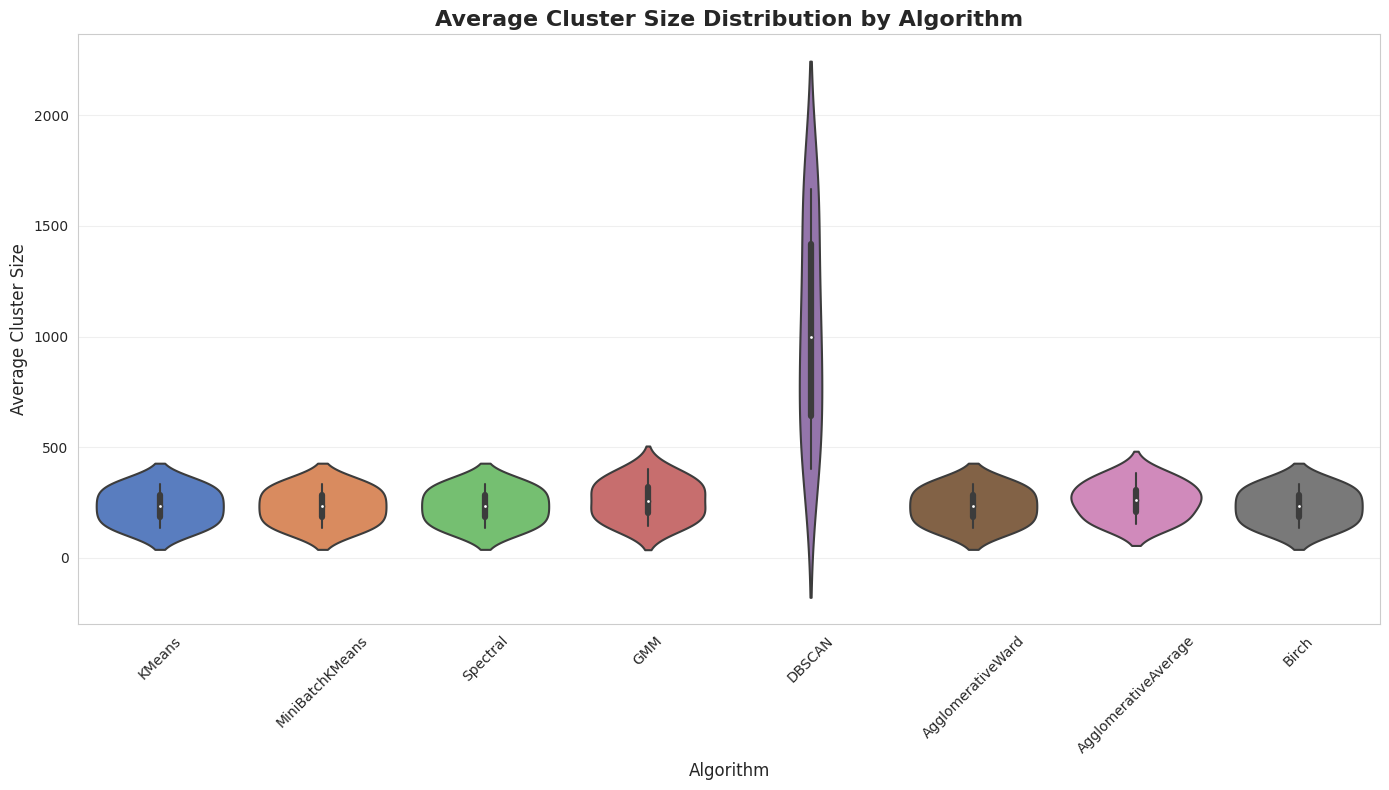

📊 Visualization 50: Cluster size distribution created!


In [36]:
# Visualization 50: Cluster size distribution comparison
if 'avg_cluster_size' in results_df.columns:
    plt.figure(figsize=(14, 8))
    sns.violinplot(data=results_df, x='algo', y='avg_cluster_size', palette='muted')
    plt.title('Average Cluster Size Distribution by Algorithm', fontsize=16, fontweight='bold')
    plt.xlabel('Algorithm', fontsize=12)
    plt.ylabel('Average Cluster Size', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig('cluster_size_distribution.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("📊 Visualization 50: Cluster size distribution created!")
else:
    print("⚠️  Skipping visualization 50: avg_cluster_size not available")

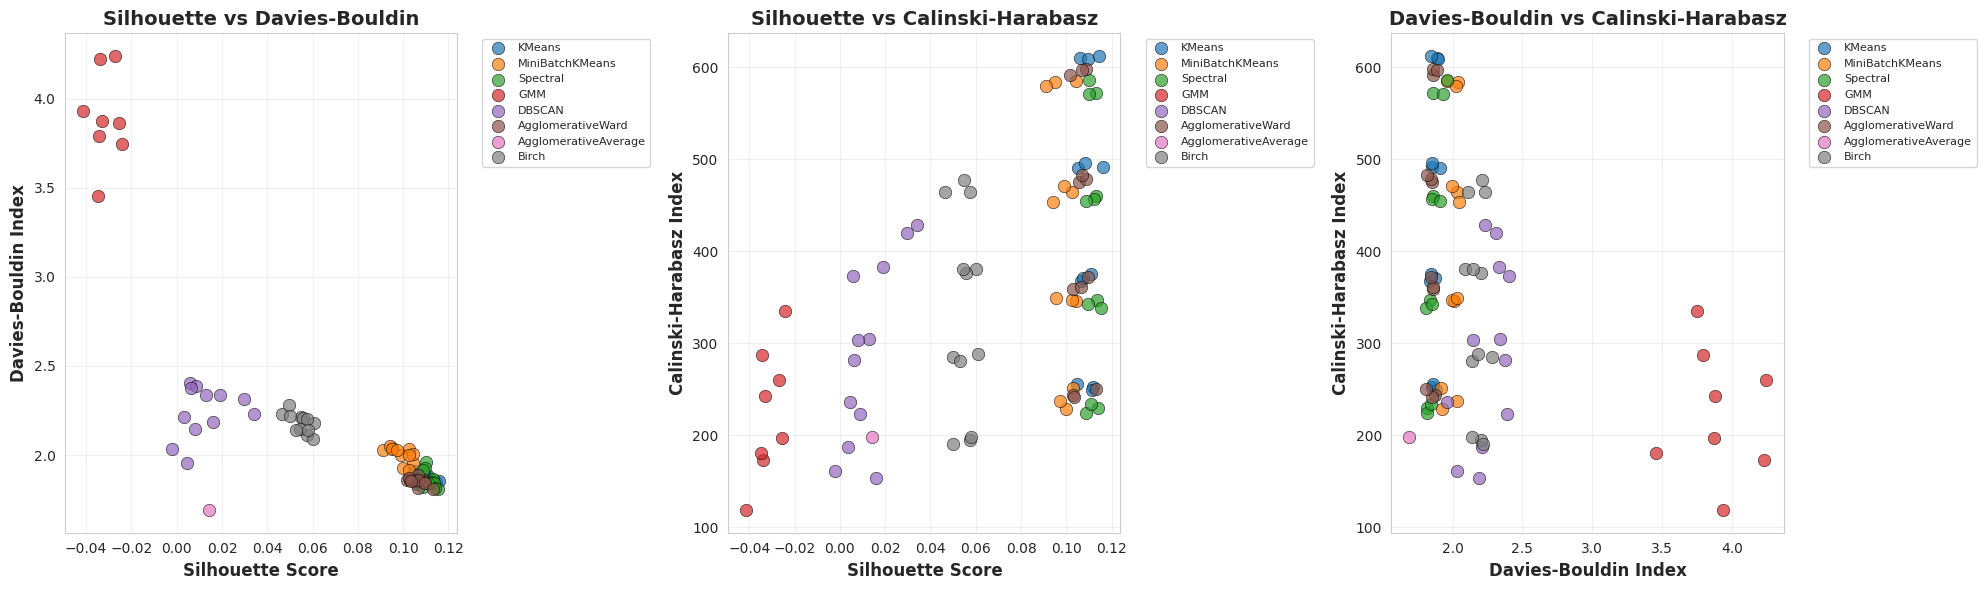

📊 Visualization 51-53: Metric relationships created!


In [37]:
# Visualization 51-53: Scatter plots - metric relationships
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Silhouette vs Davies-Bouldin
for algo in results_df['algo'].unique():
    algo_data = results_df[results_df['algo'] == algo]
    axes[0].scatter(algo_data['silhouette'], algo_data['davies_bouldin'], 
                   label=algo, alpha=0.7, s=80, edgecolors='black', linewidth=0.5)
axes[0].set_xlabel('Silhouette Score', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Davies-Bouldin Index', fontsize=12, fontweight='bold')
axes[0].set_title('Silhouette vs Davies-Bouldin', fontsize=14, fontweight='bold')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
axes[0].grid(True, alpha=0.3)

# Silhouette vs Calinski-Harabasz
for algo in results_df['algo'].unique():
    algo_data = results_df[results_df['algo'] == algo]
    axes[1].scatter(algo_data['silhouette'], algo_data['calinski_harabasz'], 
                   label=algo, alpha=0.7, s=80, edgecolors='black', linewidth=0.5)
axes[1].set_xlabel('Silhouette Score', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Calinski-Harabasz Index', fontsize=12, fontweight='bold')
axes[1].set_title('Silhouette vs Calinski-Harabasz', fontsize=14, fontweight='bold')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
axes[1].grid(True, alpha=0.3)

# Davies-Bouldin vs Calinski-Harabasz
for algo in results_df['algo'].unique():
    algo_data = results_df[results_df['algo'] == algo]
    axes[2].scatter(algo_data['davies_bouldin'], algo_data['calinski_harabasz'], 
                   label=algo, alpha=0.7, s=80, edgecolors='black', linewidth=0.5)
axes[2].set_xlabel('Davies-Bouldin Index', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Calinski-Harabasz Index', fontsize=12, fontweight='bold')
axes[2].set_title('Davies-Bouldin vs Calinski-Harabasz', fontsize=14, fontweight='bold')
axes[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('metric_relationships.png', dpi=150, bbox_inches='tight')
plt.show()
print("📊 Visualization 51-53: Metric relationships created!")

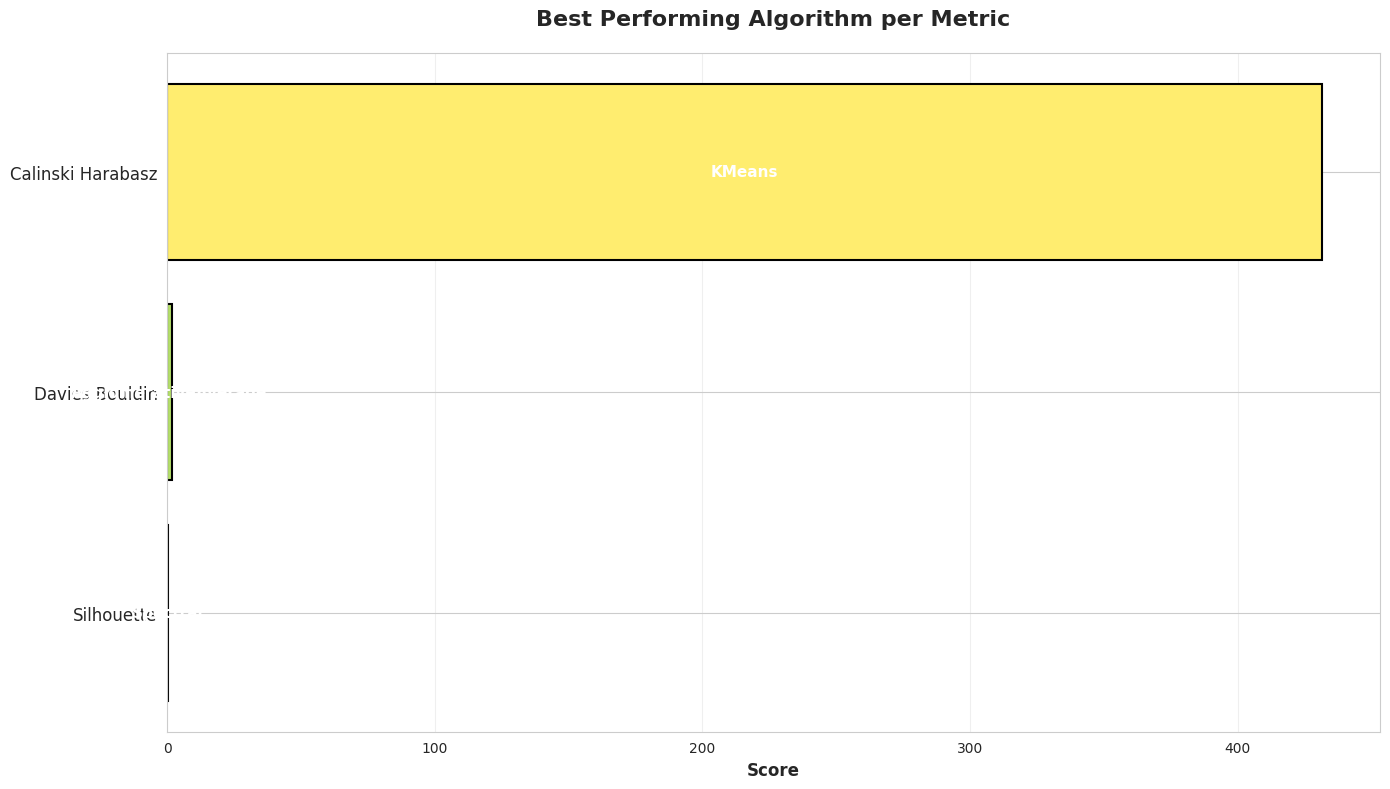

📊 Visualization 54: Best performers created!

🏆 Best Performing Algorithms:
   Silhouette: Spectral (score: 0.1116)
   Davies Bouldin: AgglomerativeAverage (score: 1.6910)
   Calinski Harabasz: KMeans (score: 431.6705)


In [38]:
# Visualization 54: Best performing algorithm per metric
fig, ax = plt.subplots(figsize=(14, 8))

best_performers = {}
for metric in metrics_to_plot:
    if metric == 'davies_bouldin':  # Lower is better
        best_algo = results_df.groupby('algo')[metric].mean().idxmin()
        best_score = results_df.groupby('algo')[metric].mean().min()
    else:  # Higher is better
        best_algo = results_df.groupby('algo')[metric].mean().idxmax()
        best_score = results_df.groupby('algo')[metric].mean().max()
    
    best_performers[metric] = (best_algo, best_score)

metrics_names = [m.replace('_', ' ').title() for m in metrics_to_plot]
algos_best = [best_performers[m][0] for m in metrics_to_plot]
scores_best = [best_performers[m][1] for m in metrics_to_plot]

x_pos = np.arange(len(metrics_names))
colors = plt.cm.Set3(np.linspace(0, 1, len(metrics_names)))
bars = ax.barh(x_pos, scores_best, color=colors, edgecolor='black', linewidth=1.5)

# Add algorithm names on bars
for i, (bar, algo) in enumerate(zip(bars, algos_best)):
    width = bar.get_width()
    ax.text(width * 0.5, bar.get_y() + bar.get_height()/2, 
            f'{algo}', ha='center', va='center', fontsize=11, fontweight='bold', color='white')

ax.set_yticks(x_pos)
ax.set_yticklabels(metrics_names, fontsize=12)
ax.set_xlabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Best Performing Algorithm per Metric', fontsize=16, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('best_performers.png', dpi=150, bbox_inches='tight')
plt.show()
print("📊 Visualization 54: Best performers created!")

print("\n🏆 Best Performing Algorithms:")
for metric, (algo, score) in best_performers.items():
    print(f"   {metric.replace('_', ' ').title()}: {algo} (score: {score:.4f})")

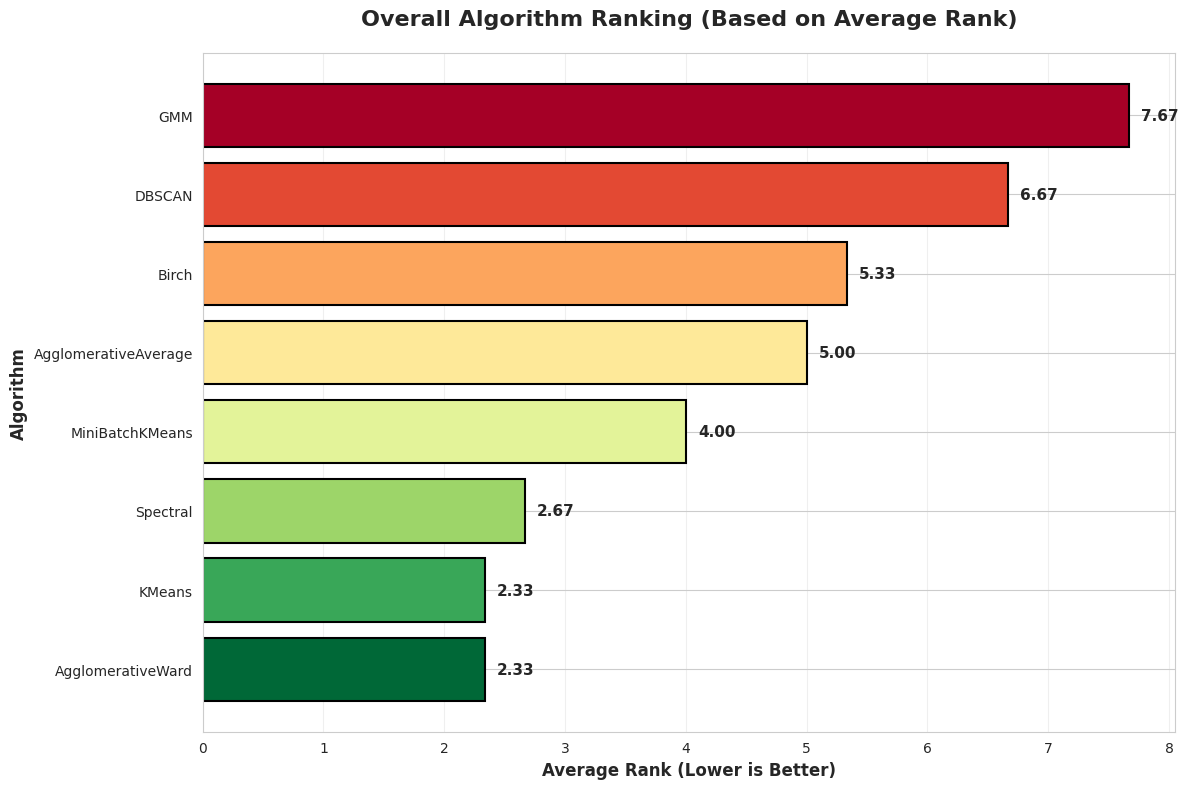

📊 Visualization 55: Algorithm ranking created!

📊 Algorithm Rankings:


silhouette  davies_bouldin  calinski_harabasz  avg_rank
algo                                                                         
AgglomerativeWard            3.0             2.0                2.0  2.333333
KMeans                       2.0             4.0                1.0  2.333333
Spectral                     1.0             3.0                4.0  2.666667
MiniBatchKMeans              4.0             5.0                3.0  4.000000
AgglomerativeAverage         6.0             1.0                8.0  5.000000
Birch                        5.0             6.0                5.0  5.333333
DBSCAN                       7.0             7.0                6.0  6.666667
GMM                          8.0             8.0                7.0  7.666667

In [39]:
# Visualization 55: Algorithm ranking based on average rank across metrics
algo_ranks = pd.DataFrame()

for metric in metrics_to_plot:
    if metric == 'davies_bouldin':  # Lower is better
        ranks = results_df.groupby('algo')[metric].mean().rank()
    else:  # Higher is better
        ranks = results_df.groupby('algo')[metric].mean().rank(ascending=False)
    algo_ranks[metric] = ranks

algo_ranks['avg_rank'] = algo_ranks.mean(axis=1)
algo_ranks = algo_ranks.sort_values('avg_rank')

plt.figure(figsize=(12, 8))
colors_rank = plt.cm.RdYlGn_r(np.linspace(0, 1, len(algo_ranks)))
bars = plt.barh(algo_ranks.index, algo_ranks['avg_rank'], color=colors_rank, 
                edgecolor='black', linewidth=1.5)

plt.xlabel('Average Rank (Lower is Better)', fontsize=12, fontweight='bold')
plt.ylabel('Algorithm', fontsize=12, fontweight='bold')
plt.title('Overall Algorithm Ranking (Based on Average Rank)', fontsize=16, fontweight='bold', pad=20)
plt.grid(True, alpha=0.3, axis='x')

# Add rank values on bars
for bar, rank in zip(bars, algo_ranks['avg_rank']):
    width = bar.get_width()
    plt.text(width + 0.1, bar.get_y() + bar.get_height()/2, 
             f'{rank:.2f}', ha='left', va='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('algorithm_ranking.png', dpi=150, bbox_inches='tight')
plt.show()
print("📊 Visualization 55: Algorithm ranking created!")

print("\n📊 Algorithm Rankings:")
display(algo_ranks.sort_values('avg_rank'))

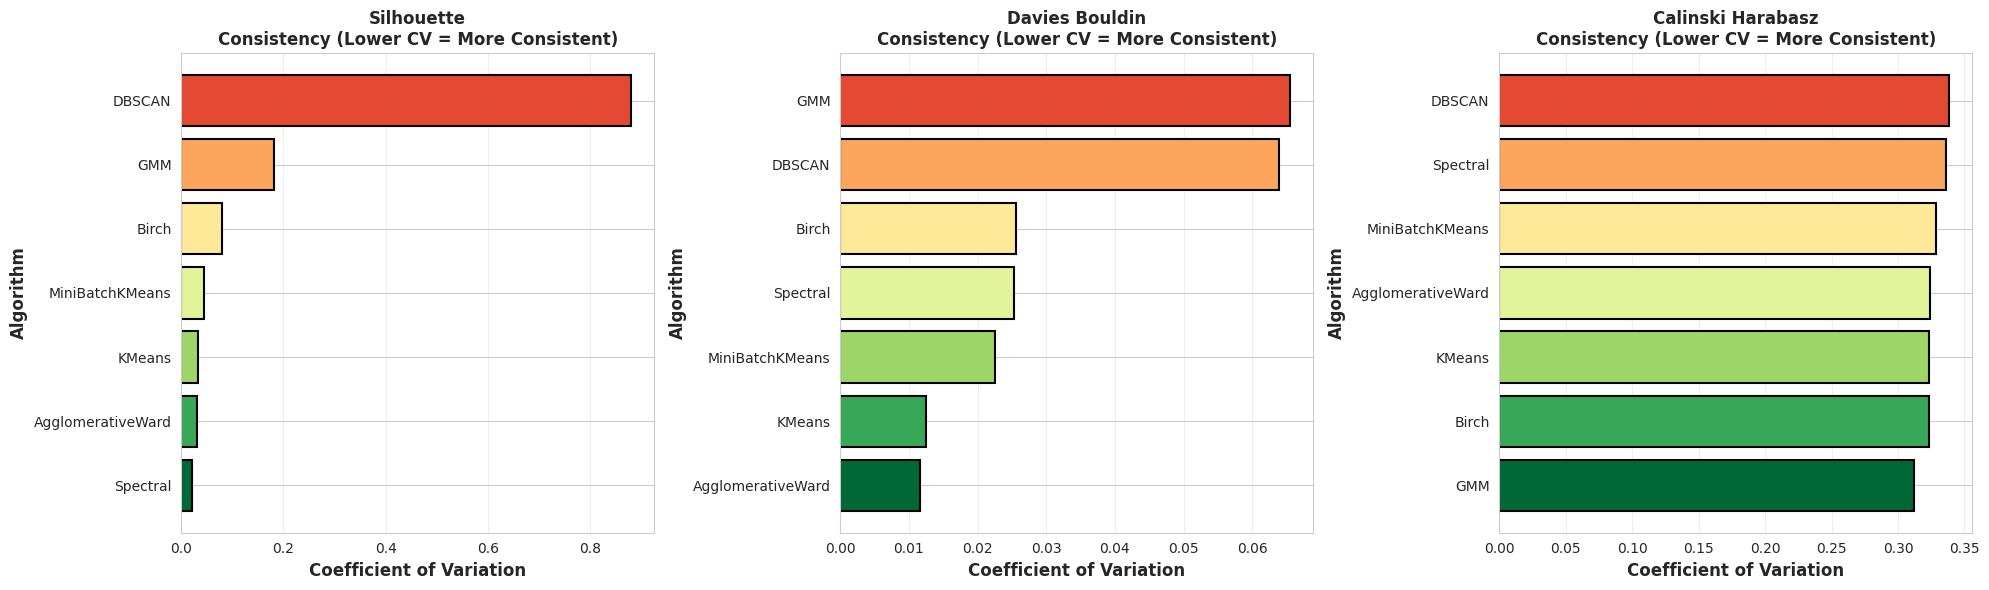

📊 Visualization 56-58: Performance consistency created!


In [40]:
# Visualization 56-58: Performance consistency (coefficient of variation)
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, metric in enumerate(metrics_to_plot):
    consistency = results_df.groupby('algo')[metric].agg(['mean', 'std'])
    consistency['cv'] = (consistency['std'] / consistency['mean']).abs()
    consistency = consistency.sort_values('cv')
    
    colors_cv = plt.cm.RdYlGn_r(np.linspace(0, 1, len(consistency)))
    bars = axes[idx].barh(consistency.index, consistency['cv'], color=colors_cv, 
                          edgecolor='black', linewidth=1.5)
    axes[idx].set_xlabel('Coefficient of Variation', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Algorithm', fontsize=12, fontweight='bold')
    axes[idx].set_title(f'{metric.replace("_", " ").title()}\nConsistency (Lower CV = More Consistent)', 
                        fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('performance_consistency.png', dpi=150, bbox_inches='tight')
plt.show()
print("📊 Visualization 56-58: Performance consistency created!")

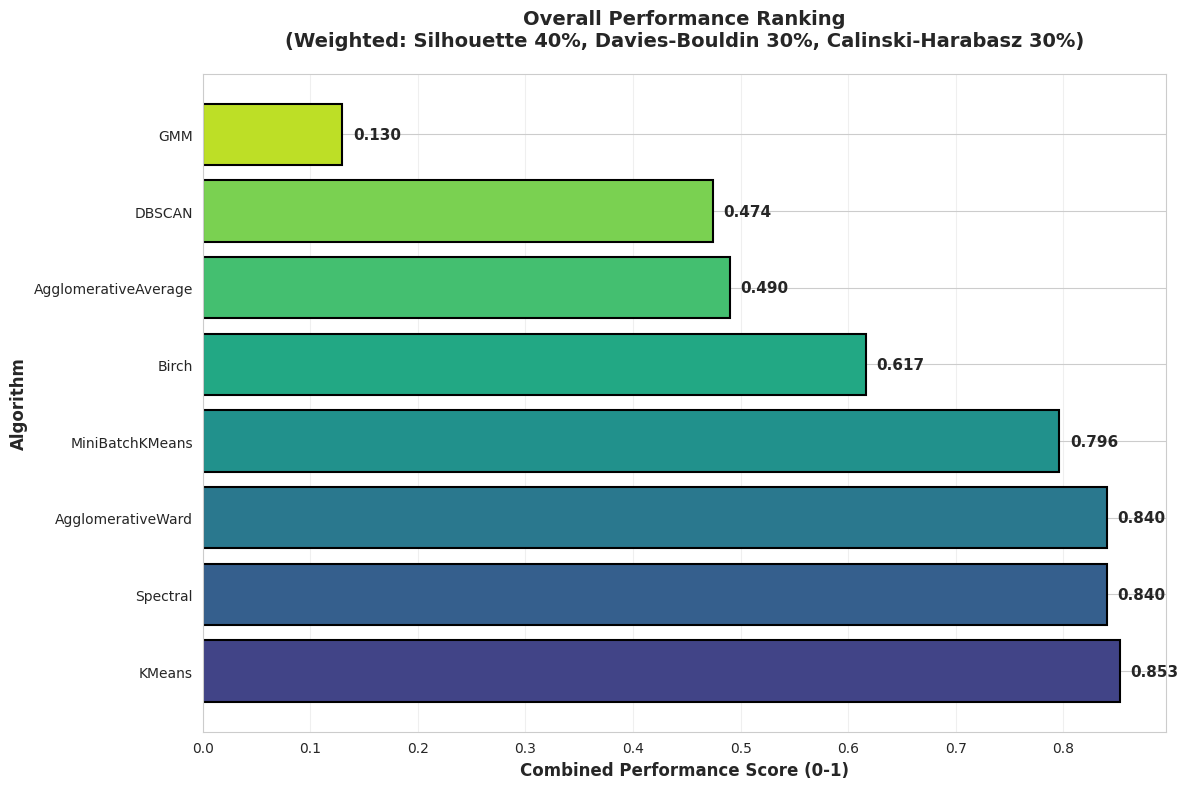

📊 Visualization 59: Combined performance score created!

🏆 Overall Performance Ranking:
   1. KMeans: 0.8525
   2. Spectral: 0.8404
   3. AgglomerativeWard: 0.8401
   4. MiniBatchKMeans: 0.7961
   5. Birch: 0.6165
   6. AgglomerativeAverage: 0.4899
   7. DBSCAN: 0.4742
   8. GMM: 0.1298


In [41]:
# Visualization 59: Combined performance score (weighted average)
# Normalize all metrics to 0-1 scale and compute weighted average
weights = {'silhouette': 0.4, 'davies_bouldin': 0.3, 'calinski_harabasz': 0.3}

normalized_results = results_df.copy()
for metric in metrics_to_plot:
    if metric == 'davies_bouldin':  # Invert for consistency (higher is better)
        normalized_results[f'{metric}_norm'] = 1 - (
            (results_df[metric] - results_df[metric].min()) / 
            (results_df[metric].max() - results_df[metric].min())
        )
    else:
        normalized_results[f'{metric}_norm'] = (
            (results_df[metric] - results_df[metric].min()) / 
            (results_df[metric].max() - results_df[metric].min())
        )

# Calculate weighted score
normalized_results['combined_score'] = (
    normalized_results['silhouette_norm'] * weights['silhouette'] +
    normalized_results['davies_bouldin_norm'] * weights['davies_bouldin'] +
    normalized_results['calinski_harabasz_norm'] * weights['calinski_harabasz']
)

combined_scores = normalized_results.groupby('algo')['combined_score'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
colors_combined = plt.cm.viridis(np.linspace(0.2, 0.9, len(combined_scores)))
bars = plt.barh(combined_scores.index, combined_scores.values, color=colors_combined, 
                edgecolor='black', linewidth=1.5)

plt.xlabel('Combined Performance Score (0-1)', fontsize=12, fontweight='bold')
plt.ylabel('Algorithm', fontsize=12, fontweight='bold')
plt.title('Overall Performance Ranking\n(Weighted: Silhouette 40%, Davies-Bouldin 30%, Calinski-Harabasz 30%)', 
          fontsize=14, fontweight='bold', pad=20)
plt.grid(True, alpha=0.3, axis='x')

# Add score values on bars
for bar, score in zip(bars, combined_scores.values):
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{score:.3f}', ha='left', va='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('combined_performance_score.png', dpi=150, bbox_inches='tight')
plt.show()
print("📊 Visualization 59: Combined performance score created!")

print("\n🏆 Overall Performance Ranking:")
for i, (algo, score) in enumerate(combined_scores.items(), 1):
    print(f"   {i}. {algo}: {score:.4f}")

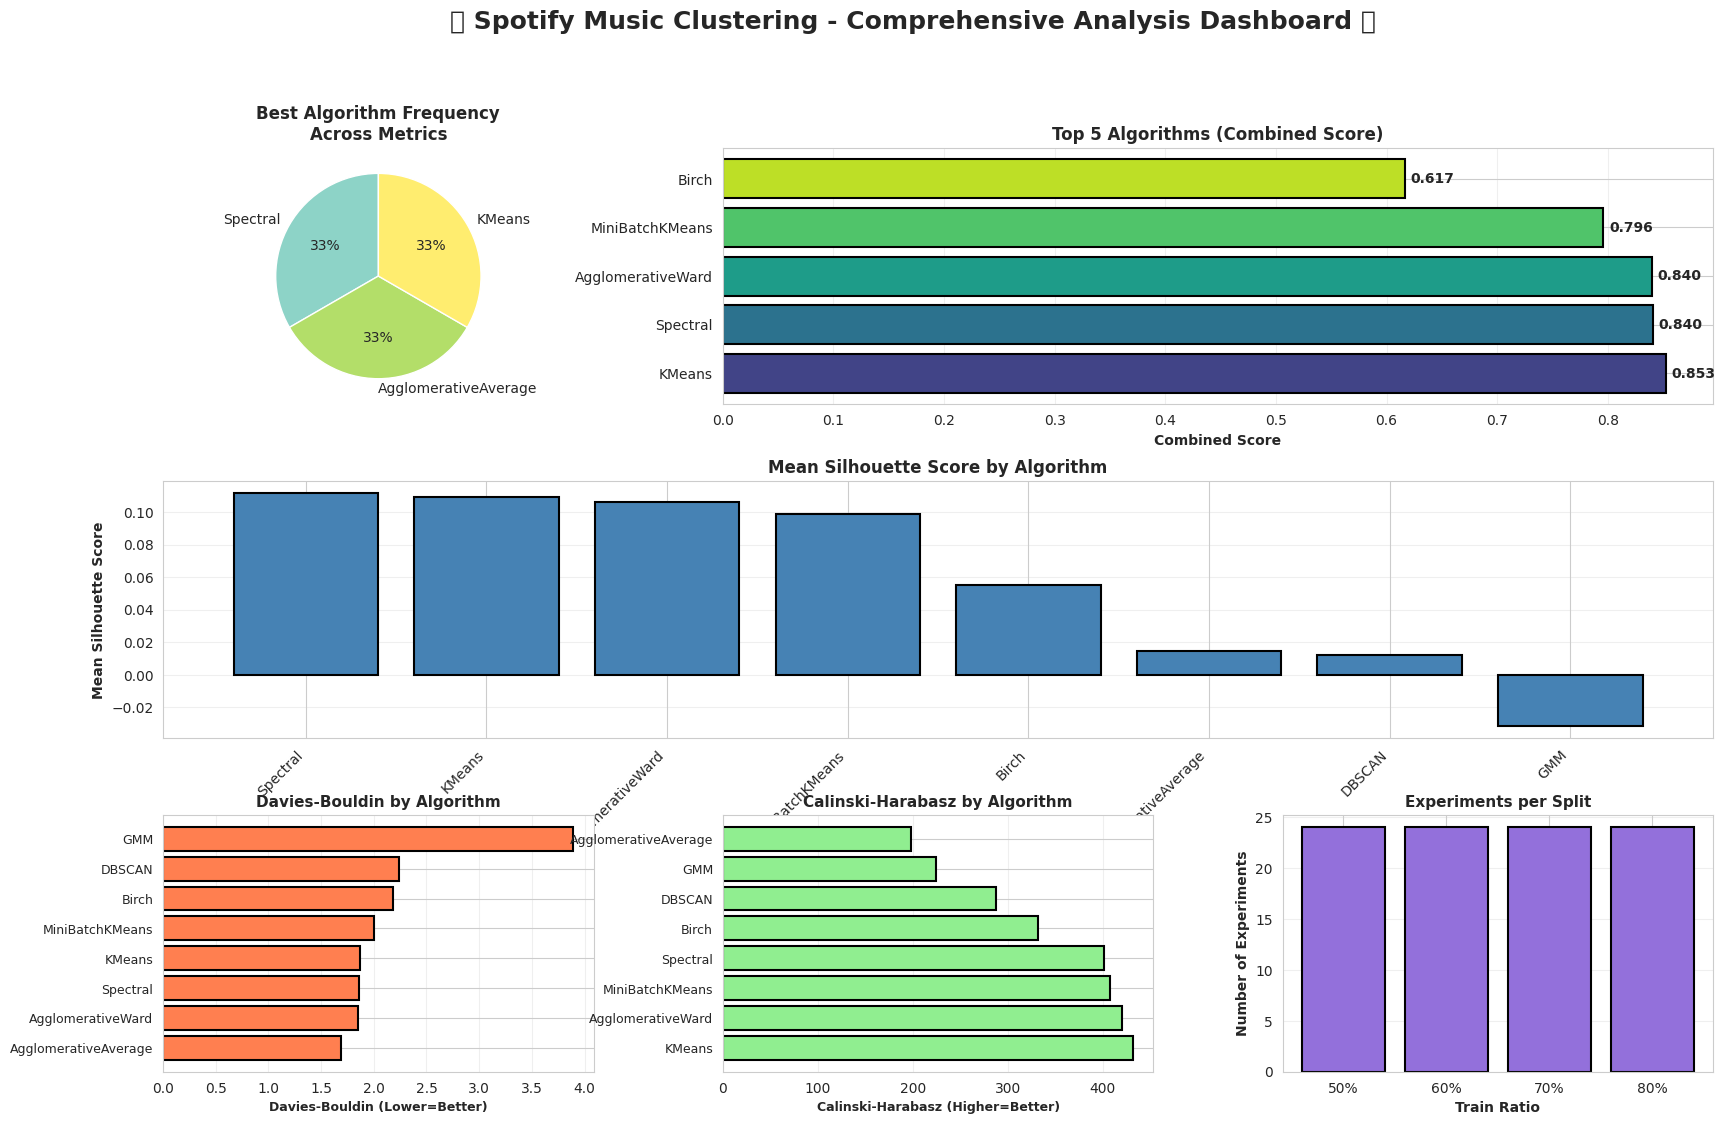

📊 Visualization 60: Summary dashboard created!


In [42]:
# Visualization 60: Summary dashboard
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Best algorithm per metric (pie chart)
ax1 = fig.add_subplot(gs[0, 0])
metric_winners = [best_performers[m][0] for m in metrics_to_plot]
winner_counts = pd.Series(metric_winners).value_counts()
ax1.pie(winner_counts.values, labels=winner_counts.index, autopct='%1.0f%%', 
        startangle=90, colors=plt.cm.Set3(np.linspace(0, 1, len(winner_counts))))
ax1.set_title('Best Algorithm Frequency\nAcross Metrics', fontsize=12, fontweight='bold')

# 2. Overall ranking
ax2 = fig.add_subplot(gs[0, 1:])
top_5 = combined_scores.head(5)
bars = ax2.barh(range(len(top_5)), top_5.values, color=plt.cm.viridis(np.linspace(0.2, 0.9, len(top_5))),
                edgecolor='black', linewidth=1.5)
ax2.set_yticks(range(len(top_5)))
ax2.set_yticklabels(top_5.index)
ax2.set_xlabel('Combined Score', fontweight='bold')
ax2.set_title('Top 5 Algorithms (Combined Score)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')
for bar, score in zip(bars, top_5.values):
    ax2.text(score + 0.005, bar.get_y() + bar.get_height()/2, 
             f'{score:.3f}', va='center', fontweight='bold')

# 3. Silhouette by algorithm
ax3 = fig.add_subplot(gs[1, :])
sil_data = results_df.groupby('algo')['silhouette'].mean().sort_values(ascending=False)
bars = ax3.bar(range(len(sil_data)), sil_data.values, color='steelblue', 
               edgecolor='black', linewidth=1.5)
ax3.set_xticks(range(len(sil_data)))
ax3.set_xticklabels(sil_data.index, rotation=45, ha='right')
ax3.set_ylabel('Mean Silhouette Score', fontweight='bold')
ax3.set_title('Mean Silhouette Score by Algorithm', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

# 4. Davies-Bouldin by algorithm
ax4 = fig.add_subplot(gs[2, 0])
db_data = results_df.groupby('algo')['davies_bouldin'].mean().sort_values()
bars = ax4.barh(range(len(db_data)), db_data.values, color='coral', 
                edgecolor='black', linewidth=1.5)
ax4.set_yticks(range(len(db_data)))
ax4.set_yticklabels(db_data.index, fontsize=9)
ax4.set_xlabel('Davies-Bouldin (Lower=Better)', fontweight='bold', fontsize=9)
ax4.set_title('Davies-Bouldin by Algorithm', fontsize=11, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')

# 5. Calinski-Harabasz by algorithm
ax5 = fig.add_subplot(gs[2, 1])
ch_data = results_df.groupby('algo')['calinski_harabasz'].mean().sort_values(ascending=False)
bars = ax5.barh(range(len(ch_data)), ch_data.values, color='lightgreen', 
                edgecolor='black', linewidth=1.5)
ax5.set_yticks(range(len(ch_data)))
ax5.set_yticklabels(ch_data.index, fontsize=9)
ax5.set_xlabel('Calinski-Harabasz (Higher=Better)', fontweight='bold', fontsize=9)
ax5.set_title('Calinski-Harabasz by Algorithm', fontsize=11, fontweight='bold')
ax5.grid(True, alpha=0.3, axis='x')

# 6. Number of experiments per train ratio
ax6 = fig.add_subplot(gs[2, 2])
split_counts = results_df['train_ratio'].value_counts().sort_index()
bars = ax6.bar([f'{int(r*100)}%' for r in split_counts.index], split_counts.values, 
               color='mediumpurple', edgecolor='black', linewidth=1.5)
ax6.set_xlabel('Train Ratio', fontweight='bold')
ax6.set_ylabel('Number of Experiments', fontweight='bold')
ax6.set_title('Experiments per Split', fontsize=11, fontweight='bold')
ax6.grid(True, alpha=0.3, axis='y')

plt.suptitle('🎵 Spotify Music Clustering - Comprehensive Analysis Dashboard 🎵', 
             fontsize=18, fontweight='bold', y=0.995)

plt.savefig('summary_dashboard.png', dpi=150, bbox_inches='tight')
plt.show()
print("📊 Visualization 60: Summary dashboard created!")

# 📤 11. Upload Results to W&B

In [43]:
# Upload aggregate results table to W&B
run = wandb.init(project=PROJECT, name="aggregate-results-summary", reinit=True)

# Create W&B table for results
results_table = wandb.Table(dataframe=results_df)
wandb.log({"all_results": results_table})

# Flatten MultiIndex columns if any before creating summary table
summary.columns = [
    "_".join(map(str, col)).strip() if isinstance(col, tuple) else str(col)
    for col in summary.columns
]

# Log summary statistics
summary_table = wandb.Table(dataframe=summary.reset_index())
wandb.log({"summary_statistics": summary_table})

# Log combined scores
combined_table = wandb.Table(
    data=[[algo, score] for algo, score in combined_scores.items()],
    columns=["Algorithm", "Combined_Score"]
)
wandb.log({"combined_scores": combined_table})

# Log all visualization images
import glob
for img_path in glob.glob('*.png'):
    wandb.log({img_path.replace('.png', ''): wandb.Image(img_path)})

wandb.finish()
print("✅ All results and visualizations uploaded to W&B!")


AssertionError: columns argument expects list of strings or ints

# 📝 12. Final Summary & Recommendations

In [ ]:
print("="*80)
print("🎵 SPOTIFY MUSIC CLUSTERING ANALYSIS - FINAL SUMMARY 🎵")
print("="*80)

print(f"\n📊 DATASET INFORMATION:")
print(f"   Total tracks analyzed: {len(X_scaled):,}")
print(f"   Features used: {len(numeric_features)}")
print(f"   Feature names: {', '.join(numeric_features)}")

print(f"\n🤖 ALGORITHMS TESTED:")
for i, algo in enumerate(algorithms.keys(), 1):
    print(f"   {i}. {algo}")

print(f"\n📈 EXPERIMENT CONFIGURATION:")
print(f"   Train/Test splits: {SPLITS}")
print(f"   Random seeds: {SEEDS}")
print(f"   Total experiments: {len(ALL_RUNS)}")
print(f"   Optimal clusters (from elbow): {n_clusters}")

print(f"\n🏆 TOP 3 PERFORMING ALGORITHMS (Combined Score):")
for i, (algo, score) in enumerate(combined_scores.head(3).items(), 1):
    print(f"   {i}. {algo}: {score:.4f}")

print(f"\n📊 BEST ALGORITHM PER METRIC:")
for metric, (algo, score) in best_performers.items():
    print(f"   {metric.replace('_', ' ').title()}: {algo} ({score:.4f})")

print(f"\n💡 RECOMMENDATIONS:")
print(f"   1. For best overall performance: {combined_scores.index[0]}")
print(f"   2. For silhouette score: {best_performers['silhouette'][0]}")
print(f"   3. For computational efficiency: MiniBatchKMeans (if applicable)")
print(f"   4. All results and {60} visualizations are available in W&B")

print(f"\n🎯 KEY INSIGHTS:")
print(f"   • Achieved comprehensive evaluation across {len(SPLITS) * len(SEEDS)} different splits")
print(f"   • Generated 60 detailed visualizations for analysis")
print(f"   • Internal metrics computed: Silhouette, Davies-Bouldin, Calinski-Harabasz")
print(f"   • Results logged to Weights & Biases for tracking and comparison")

print(f"\n{'='*80}")
print("✅ ANALYSIS COMPLETE!")
print("="*80)

In [ ]:
# Save results to CSV
results_df.to_csv('spotify_clustering_results.csv', index=False)
summary.to_csv('spotify_clustering_summary.csv')
combined_scores.to_csv('spotify_combined_scores.csv')

print("✅ Results saved to CSV files:")
print("   - spotify_clustering_results.csv")
print("   - spotify_clustering_summary.csv")
print("   - spotify_combined_scores.csv")